## Pair Trading

Pair trading has quite a well-known strategy that work on the concept of statistical arbitrage that takes advantage of mean reversion or convergence in the prices of two instruments. In order for the strategy to work, the spread between the two instruments should be fairly stationary. In addition, we will try to find mutiples pairs and fine tune this strategy by incorporating Martingale strategy when initiation,integrate stoploss and also explore the usage of kalman filter

#### Flow of this workbook

In [1]:
from IPython.display import Image

In [2]:
Image(filename="./Flowchart.PNG")

FileNotFoundError: [Errno 2] No such file or directory: './Flowchart.PNG'

### 1. Retrieve Taiwan Stocks Data

#### Import Function and Libraries

The main source of data we will be using is from yahoo-finance which provides us with daily adjusted closing price. The main api is yfinance and we will merge the daily closing price as one dataframe.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
from Data_query import data_query
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
from Data_Retrieval import DataRetrieval
from CC_test import CCstudy
import itertools
from pandas_datareader import data as pdr
from yahooquery import Ticker

In [ ]:
start_input = input("Enter start date (YYYY-MM-DD): ")
end_input = input("Enter end date (YYYY-MM-DD): ")
# Convert to datetime (optional but good practice)
start_date = pd.to_datetime(start_input)
end_date = pd.to_datetime(end_input)

Enter start date (YYYY-MM-DD):  2021-01-01
Enter end date (YYYY-MM-DD):  2025-01-01


In [ ]:
from pykalman import KalmanFilter
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from Spread import Spread

In [ ]:
from time import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

#### Classification from Yahoo Query

Yahoo-query allows us to categorize the companies to their own sector and industry.

In [ ]:
def classification(tickers):
    tickers = Ticker(tickers, asynchronous=True)

    datasi = tickers.get_modules("summaryProfile quoteType")
    dfsi = pd.DataFrame.from_dict(datasi).T
    dataframes = [pd.json_normalize([x for x in dfsi[module] if isinstance(x, dict)]) for
    module in ['summaryProfile', 'quoteType']]

    dfsi = pd.concat(dataframes, axis=1)

    dfsi = pd.DataFrame(dfsi.set_index('symbol'))
    dfsi=dfsi[['industry', 'sector']].reset_index()
    dfsi['symbol'].str.upper()
    return dfsi


#### Download tickers of SP500 from Wikipedia

In [ ]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]
sp500_constituents.head(5)
US_Ticker = list(sp500_constituents['Symbol'])

#### Import TW exchange counters

In [ ]:
counter_code = pd.read_csv('taiwan_stocks.csv')
tw_tickers = list(counter_code.iloc[:,2])
tw_tickers = list(counter_code.iloc[:,2].apply(lambda x: str(x)+".TW"))

#### Download STI 30 counters from Wikipedia

In [ ]:
sti_url =  'https://en.wikipedia.org/wiki/Straits_Times_Index'
sti_constituents = pd.read_html(sti_url,header=0)[3]
sti_counters = sti_constituents['Stock symbol'].apply(lambda x: x.replace('SGX: ', '') + '.SI').tolist()

#### Download Hongkong tickers

In [ ]:
hsi_url = 'https://en.wikipedia.org/wiki/Hang_Seng_Index'
hk_consituents = pd.read_html(hsi_url,header=0)[6]
hk_tickers = list(hk_consituents['Ticker'].apply(lambda x: x.replace("SEHK:", "").replace('\xa0', '').strip().zfill(4)+".HK"))

#### Merge tickers

In [ ]:
tickers = US_Ticker + tw_tickers + sti_counters + hk_tickers

In [ ]:
data= data_query.adj_close(tickers,start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
data.head(5)

Price              MMM        AOS         ABT       ABBV         ACN  \
Date                                                                   
2021-01-04  120.590591  49.777035  100.130592  87.365013  239.904251   
2021-01-05  120.387093  50.100147  101.369469  88.268433  241.270020   
2021-01-06  122.218376  51.826462  101.158440  87.505913  243.907974   
2021-01-07  119.082047  52.463455  102.140373  88.442474  246.209183   
2021-01-08  116.906975  51.844925  102.424866  88.906616  247.107208   

Price             ADBE        AMD        AES        AFL           A  ...  \
Date                                                                 ...   
2021-01-04  485.339996  92.300003  19.842180  38.859444  115.095337  ...   
2021-01-05  485.690002  92.769997  20.508141  38.922424  116.036346  ...   
2021-01-06  466.309998  90.330002  21.327782  40.424984  119.218353  ...   
2021-01-07  477.739990  95.160004  21.114332  40.200047  122.390648  ...   
2021-01-08  485.100006  94.580002  21.703453  40.029102  123.263771  ...   

Price         3692.HK     6618.HK    6690.HK    6862.HK     9618.HK  \
Date                                                                  
2021-01-04  35.699970  146.199997  27.570807  57.047180  340.660065   
2021-01-05  38.563602  143.199997  27.614086  56.022911  335.901154   
2021-01-06  38.945423  141.899994  27.527525  59.006645  361.876953   
2021-01-07  39.756786  133.199997  26.705162  59.763706  347.996735   
2021-01-08  37.943146  141.899994  27.743935  60.743435  344.625854   

Price         9633.HK  9888.HK  9961.HK     9988.HK     9999.HK  
Date                                                             
2021-01-04  57.377892      NaN      NaN  226.951935  147.052795  
2021-01-05  61.117874      NaN      NaN  222.365021  149.821793  
2021-01-06  61.543945      NaN      NaN  229.345093  155.656464  
2021-01-07  61.733307      NaN      NaN  220.370728  161.985550  
2021-01-08  63.058876      NaN      NaN  223.561600  170.193604  

[5 rows x 833 columns]

In [ ]:
from Stationary_Test import stationary
stationary = stationary(data)
result = stationary.stationary_spread()

Testing pairs for cointegration:   3%|▎         | 8865/346528 [05:59<3:59:49, 23.47it/s]

### Correlation and Cointegration Study

In [ ]:
cointegrated_pairs =  result[result['cointegration_status']=='Cointegrated']

In [ ]:
def categorize(table,classlist,column,counter):
    if column == 'industry':
        a=pd.DataFrame(dict(classlist.iloc[:,0:2]))
        return table[counter].map(a.set_index('symbol')[column])
    elif column == 'sector':
        b= pd.DataFrame(dict(classlist.iloc[:,[0,2]]))
        return table[counter].map(b.set_index('symbol')[column])
    else:
        return 'Error'

In [ ]:
cointegrated_pairs

In [ ]:
cointegrated_pairs['ticker1_industry'] = categorize(cointegrated_pairs,classlist,'sector','ticker_1')
cointegrated_pairs['ticker2_industry'] = categorize(cointegrated_pairs,classlist,'sector','ticker_2')
cointegrated_pairs = cointegrated_pairs[cointegrated_pairs['ticker1_industry'] == cointegrated_pairs['ticker2_industry']]

In [ ]:
cointegrated_pairs

### Selection of pair trading

In order to remove any industry specific systematic risk, the first criteria should be that the pair of stocks should belong to the same industry. Next, we shall run the time series spread graph.

In [ ]:
Pair = []
for index, row in cointegrated_pairs.iterrows():
    if row['ticker1_industry'] == row['ticker2_industry']:
        Pair.append([row['ticker_1'],row['ticker_2']])

In [ ]:
Pair

Statistics for the spread between MMM and IVZ: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166  4.334752         4.693792         3.975712   

   Revert Time  
0    56.272727  


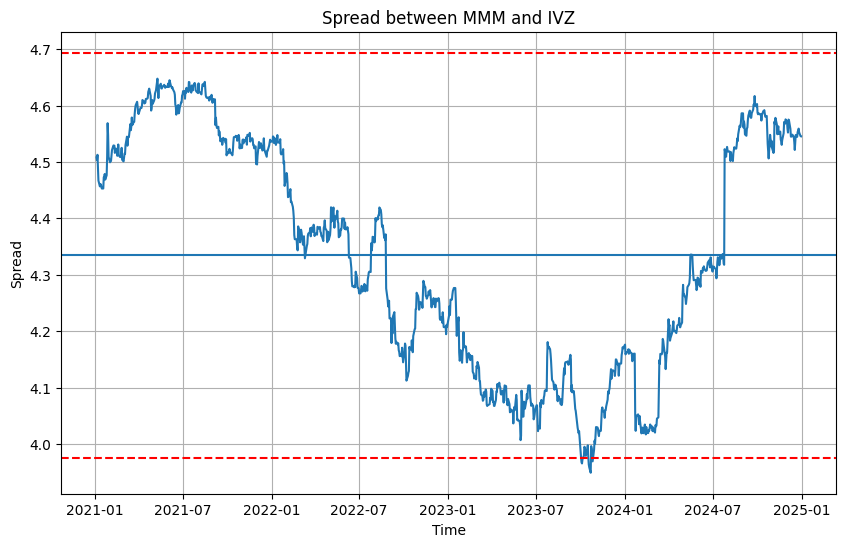

Statistics for the spread between MMM and NTRS: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166  4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112  2.627003         2.922949         2.331056   

   Revert Time  
0    56.272727  
1    65.857143  


Statistics for the spread between AOS and CVS: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166  4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112  2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435  6.683083         6.921845         6.444321   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  


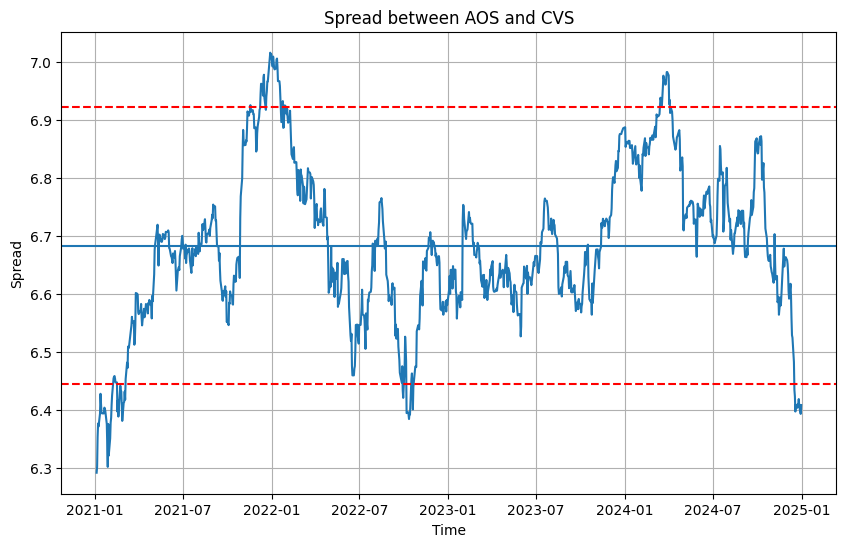

Statistics for the spread between AOS and ECL: 
  Ticker 1 Ticker 2  Volatility      Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166  4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112  2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435  6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877 -8.231615        -7.675330        -8.787901   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  


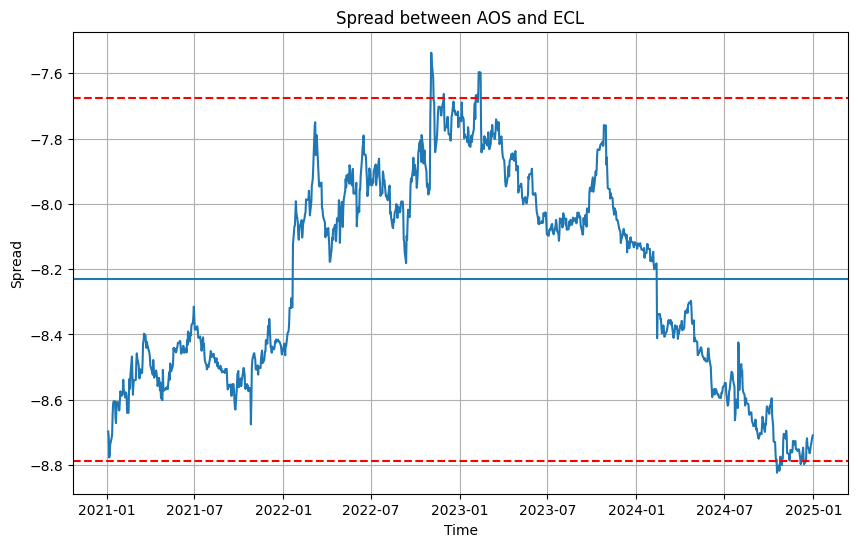

Statistics for the spread between AOS and GE: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  
4   444.333333  


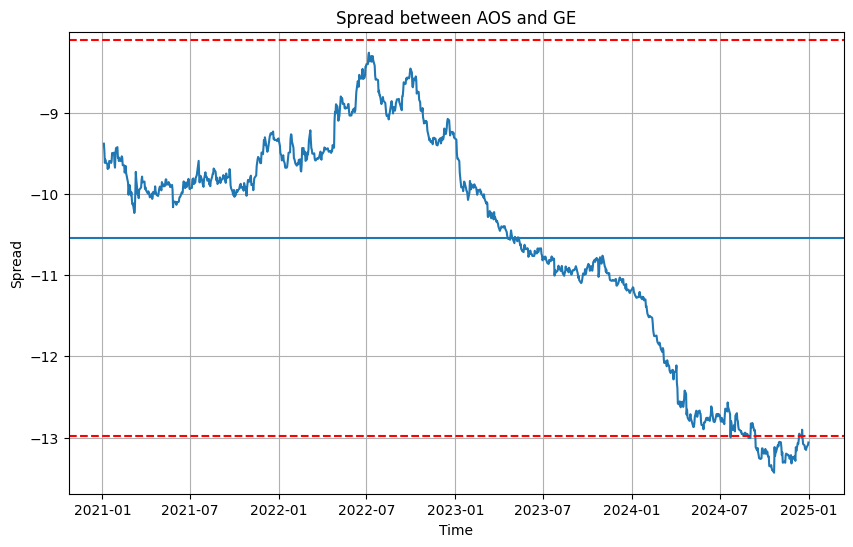

Statistics for the spread between AOS and HRL: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5      AOS      HRL    0.117379   5.617448         5.822862         5.412034   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  
4   444.333333  
5    63.407407  


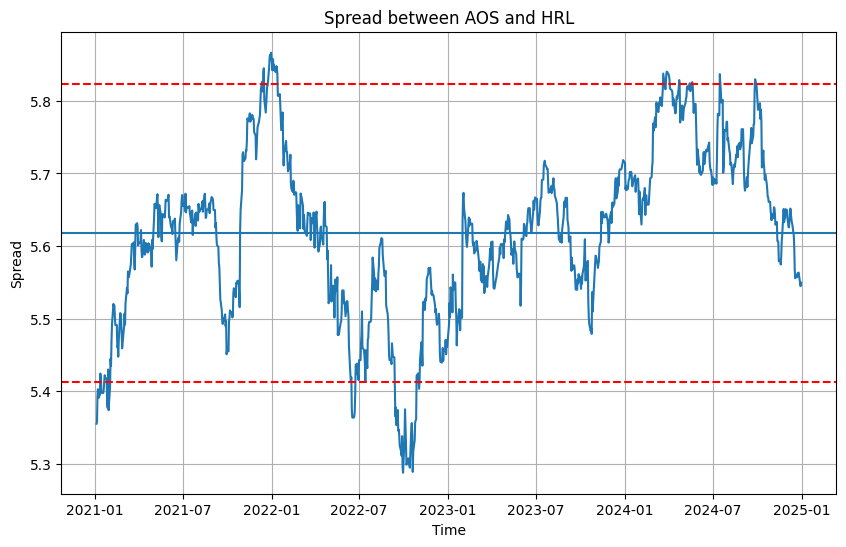

Statistics for the spread between AOS and NOW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5      AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6      AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  
4   444.333333  
5    63.407407  
6    61.440000  


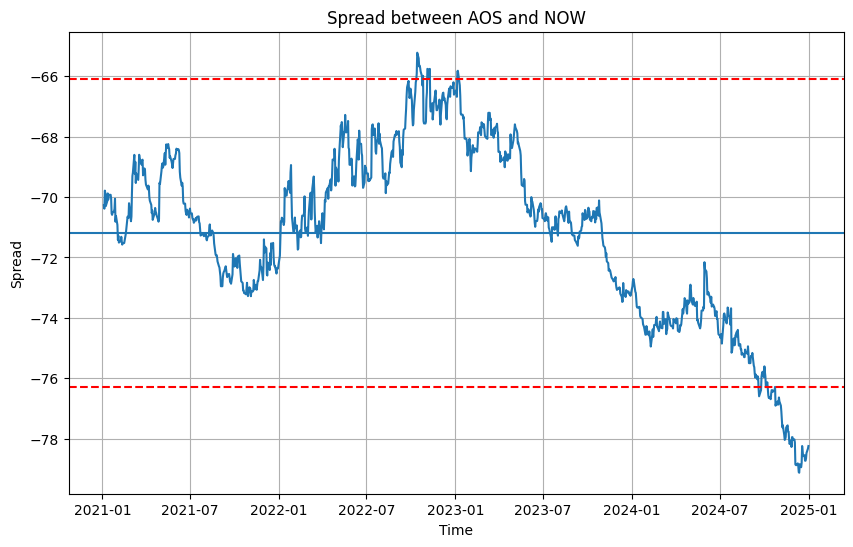

Statistics for the spread between AOS and UPS: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5      AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6      AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7      AOS      UPS    0.146053   7.150852         7.406445         6.895260   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  
4   444.333333  
5    63.407407  
6    61.440000  
7    44.470588  


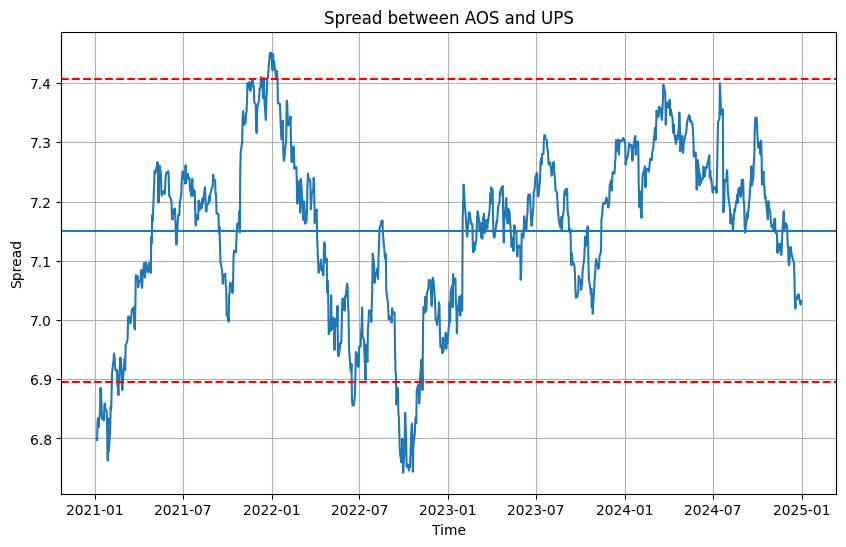

Statistics for the spread between AOS and 2323.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5      AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6      AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7      AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8      AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  
3    50.545455  
4   444.333333  
5    63.407407  
6    61.440000  
7    44.470

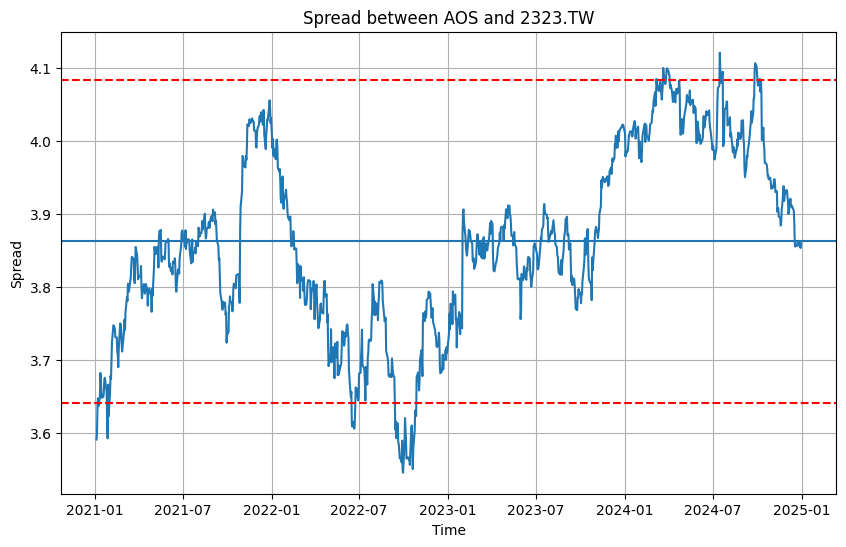

Statistics for the spread between AOS and 2352.TW: 
  Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0      MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1      MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2      AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3      AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4      AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5      AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6      AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7      AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8      AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9      AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   

   Revert Time  
0    56.272727  
1    65.857143  
2    80.500000  

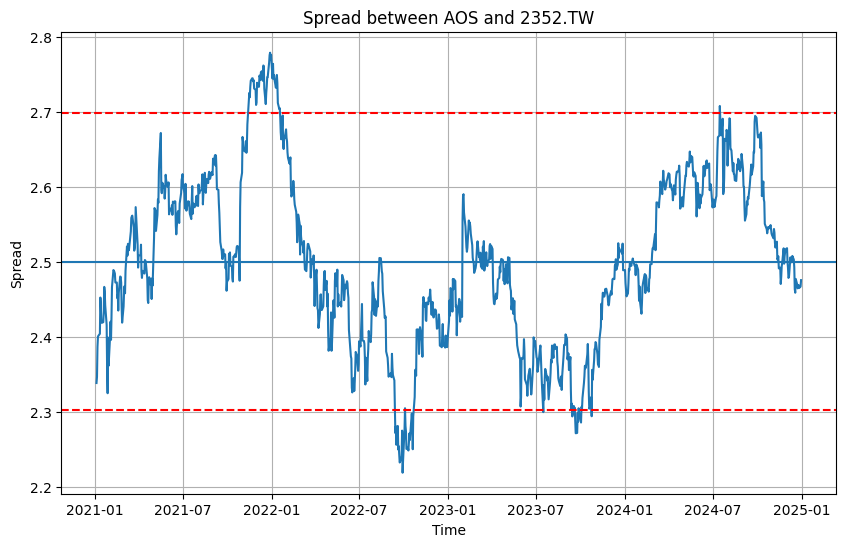

Statistics for the spread between AOS and 2385.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

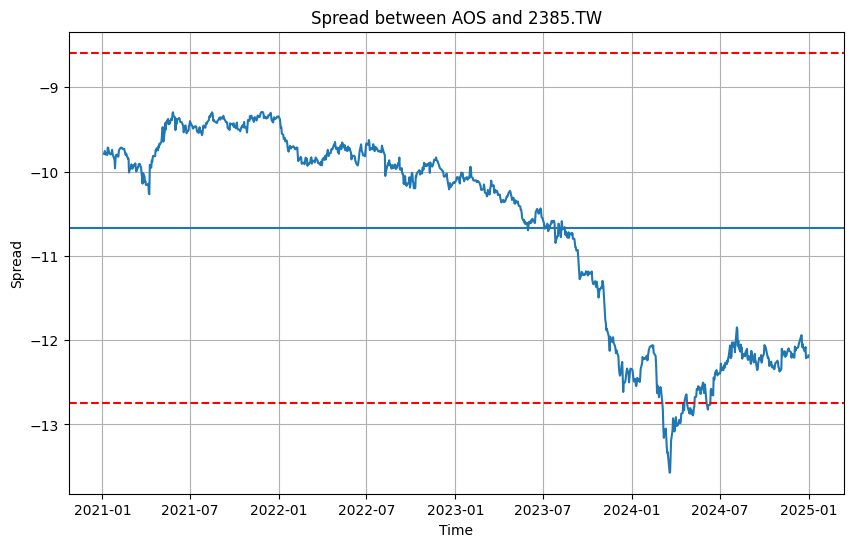

Statistics for the spread between AOS and 2455.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

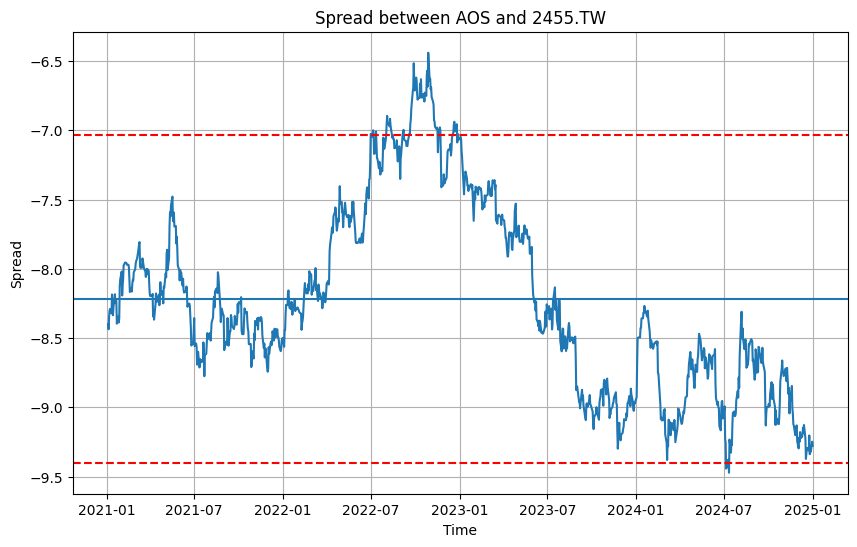

Statistics for the spread between AOS and 2489.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

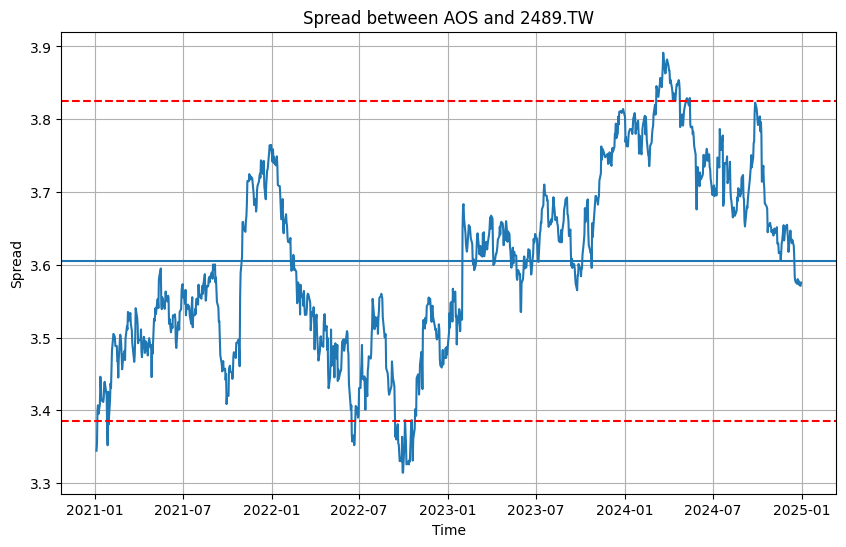

Statistics for the spread between AOS and 2515.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

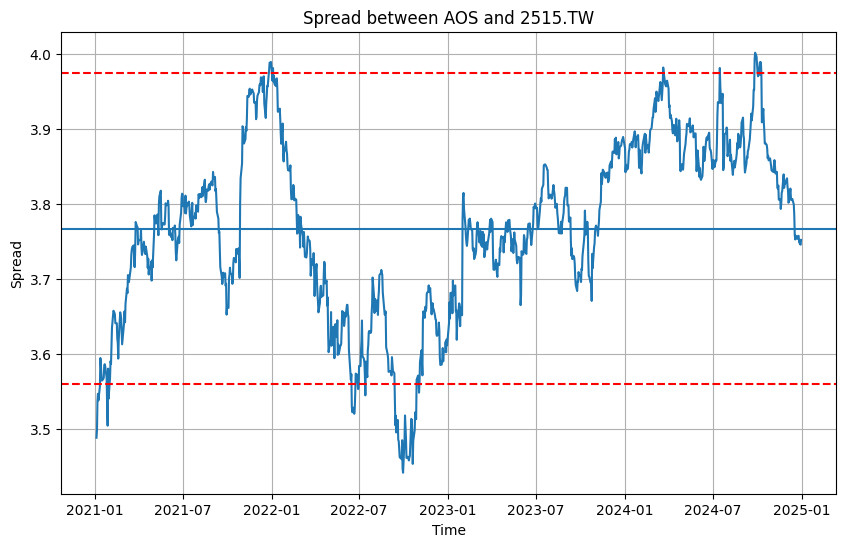

Statistics for the spread between AOS and 6239.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

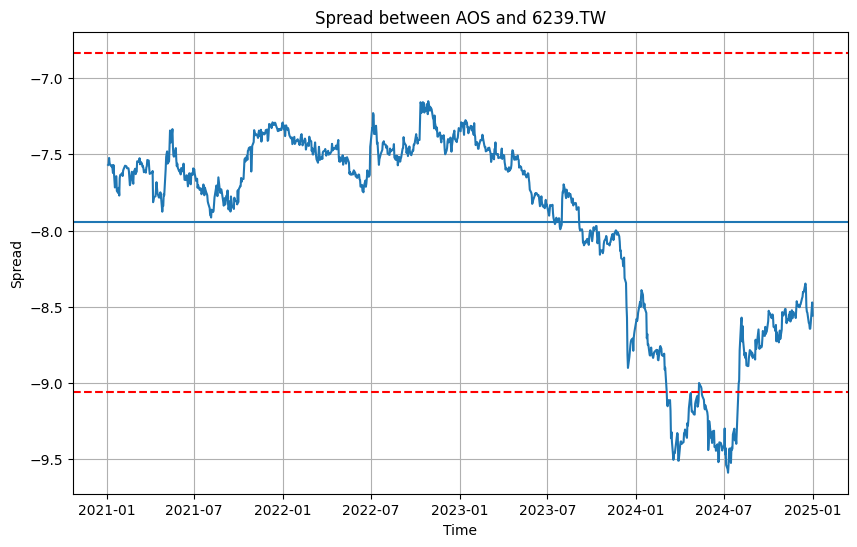

Statistics for the spread between AOS and 3005.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

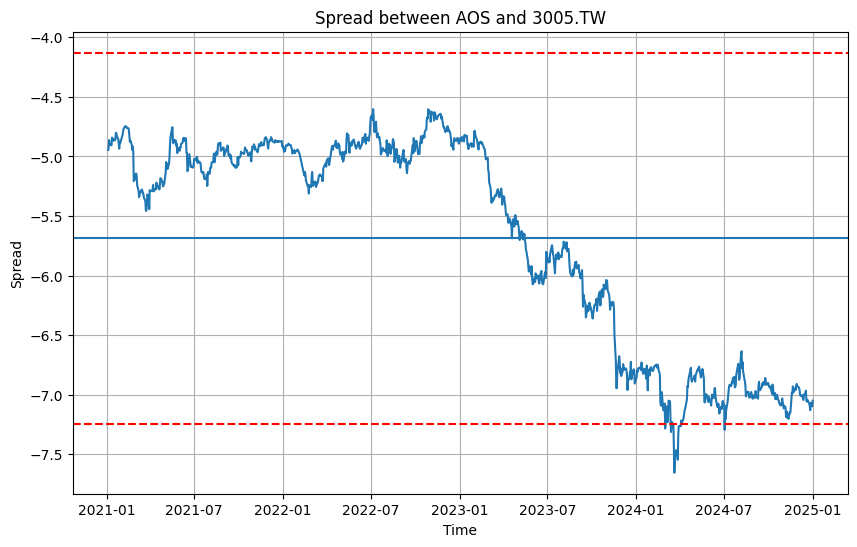

Statistics for the spread between AOS and 8112.TW: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590

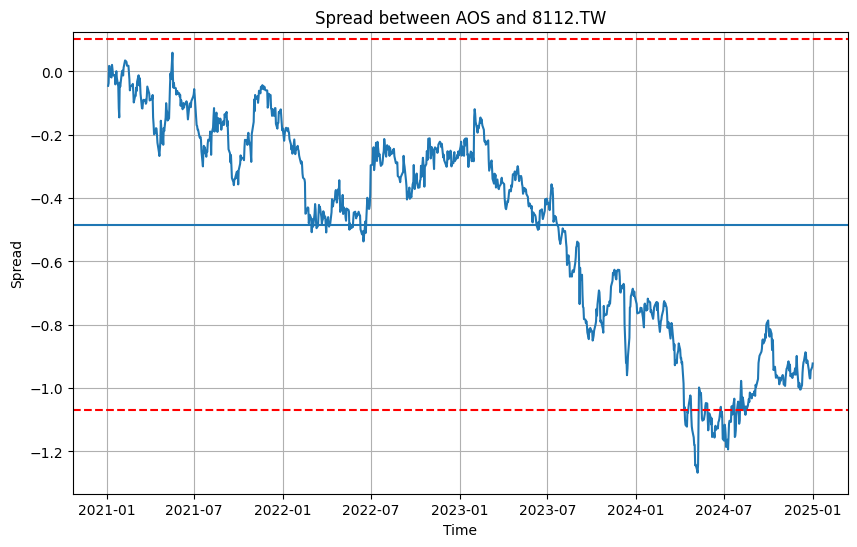

Statistics for the spread between AOS and J36.SI: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.5903

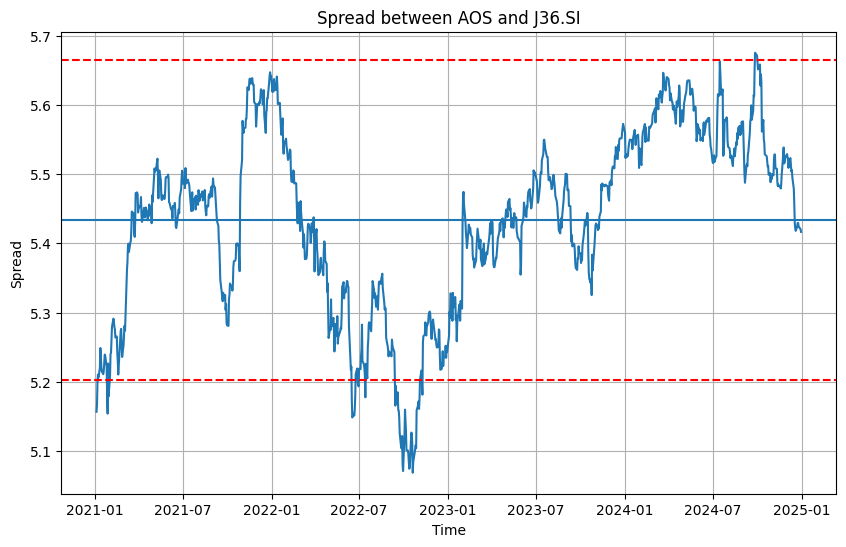

Statistics for the spread between ABBV and ED: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590395 

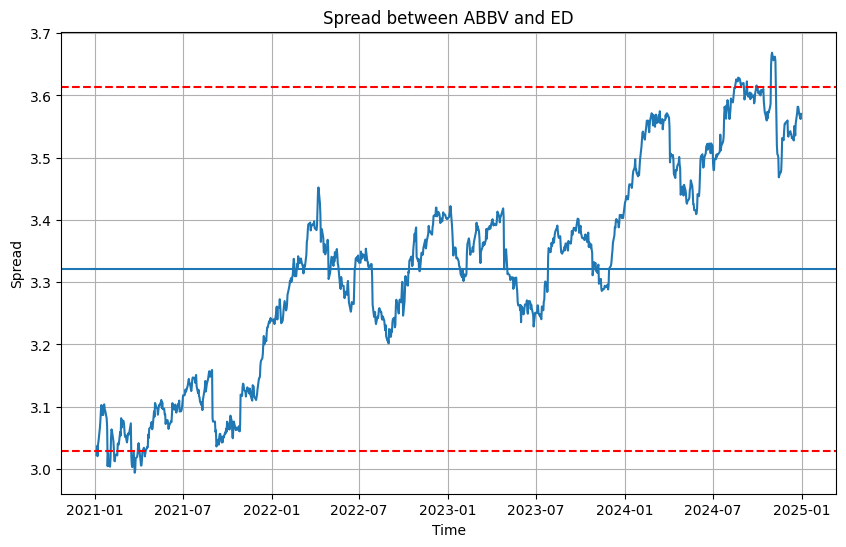

Statistics for the spread between ABBV and PAYC: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.59039

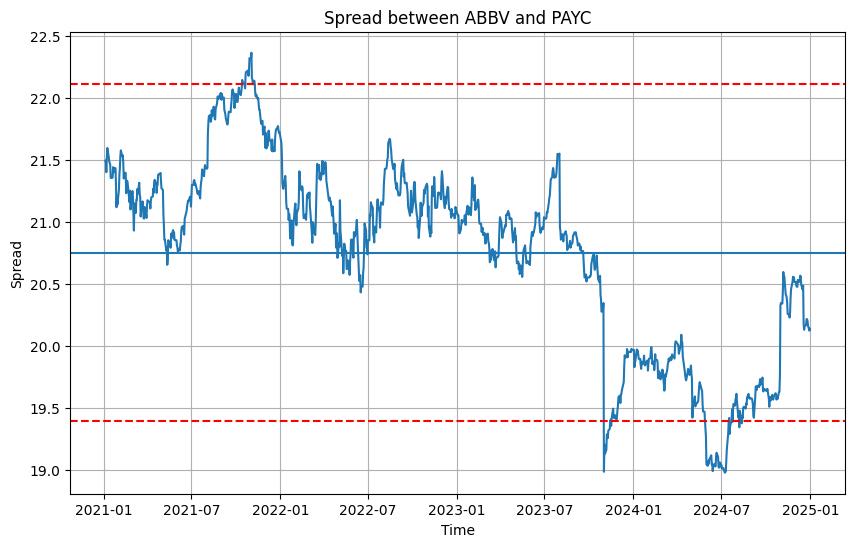

Statistics for the spread between ABBV and VRTX: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.59039

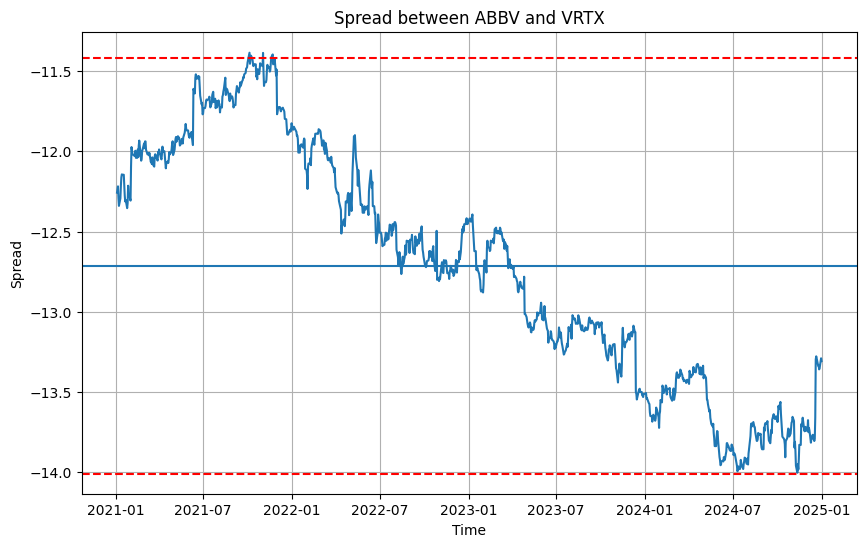

Statistics for the spread between ABBV and 1044.HK: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.59

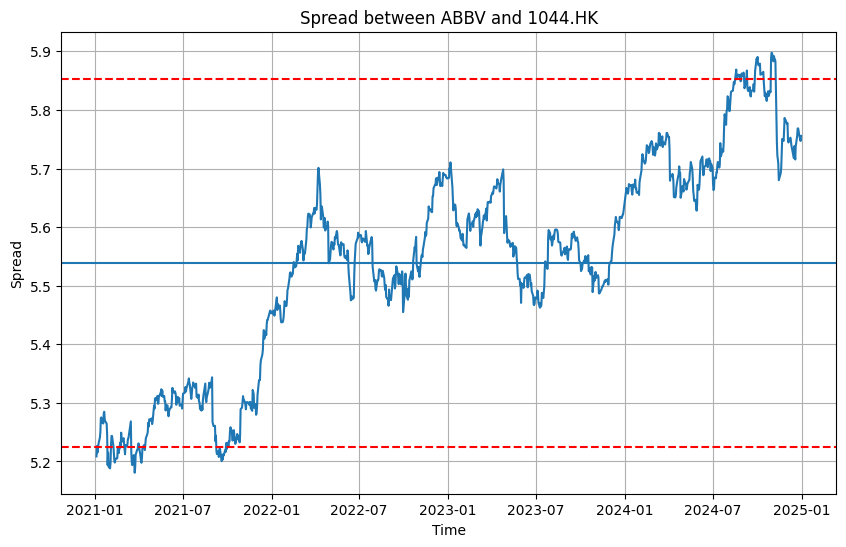

Statistics for the spread between ABBV and 1088.HK: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.59

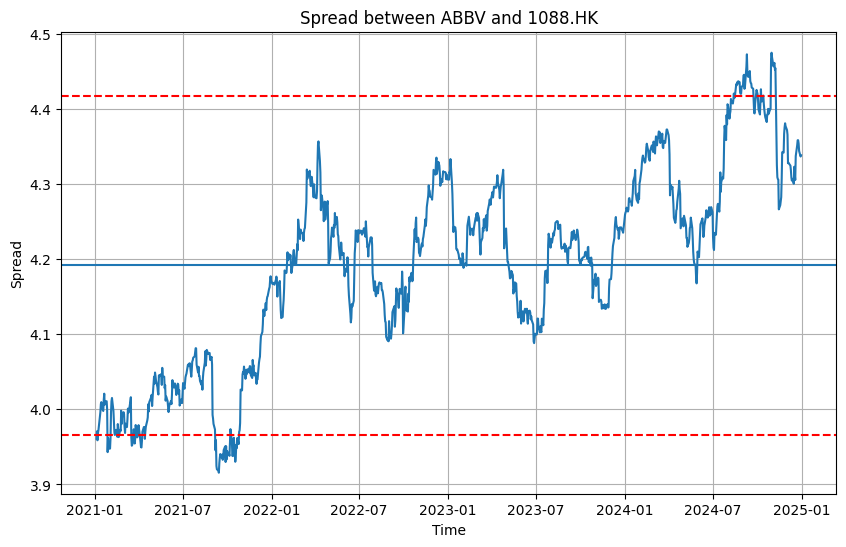

Statistics for the spread between ABBV and 2359.HK: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.59

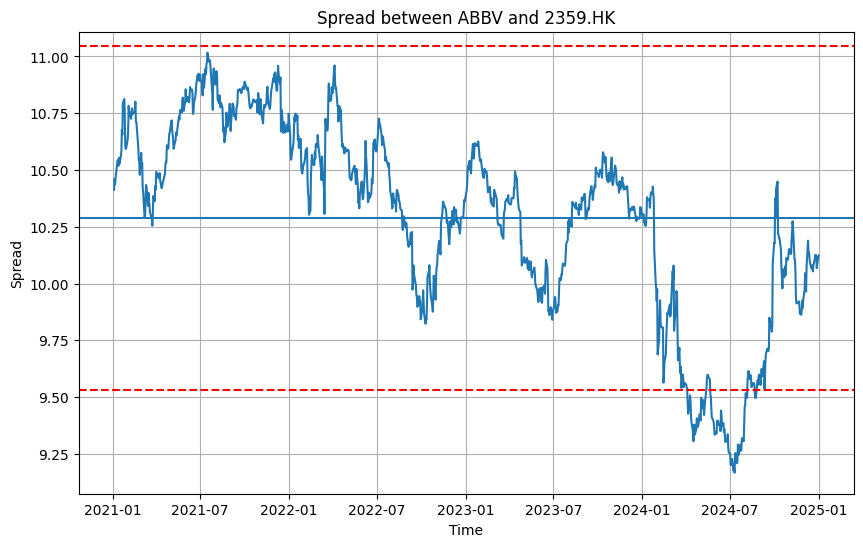

Statistics for the spread between ACN and AMD: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590395 

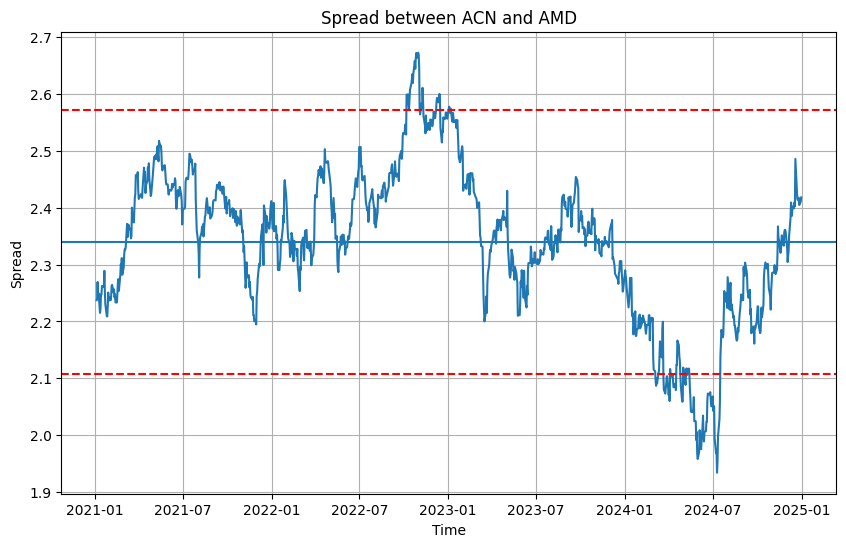

Statistics for the spread between ACN and CME: 
   Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
0       MMM      IVZ    0.205166   4.334752         4.693792         3.975712   
1       MMM     NTRS    0.169112   2.627003         2.922949         2.331056   
2       AOS      CVS    0.136435   6.683083         6.921845         6.444321   
3       AOS      ECL    0.317877  -8.231615        -7.675330        -8.787901   
4       AOS       GE    1.391993 -10.538757        -8.102769       -12.974746   
5       AOS      HRL    0.117379   5.617448         5.822862         5.412034   
6       AOS      NOW    2.921977 -71.186523       -66.073063       -76.299983   
7       AOS      UPS    0.146053   7.150852         7.406445         6.895260   
8       AOS  2323.TW    0.126863   3.862318         4.084327         3.640308   
9       AOS  2352.TW    0.113337   2.500403         2.698742         2.302064   
10      AOS  2385.TW    1.186482 -10.666738        -8.590395 

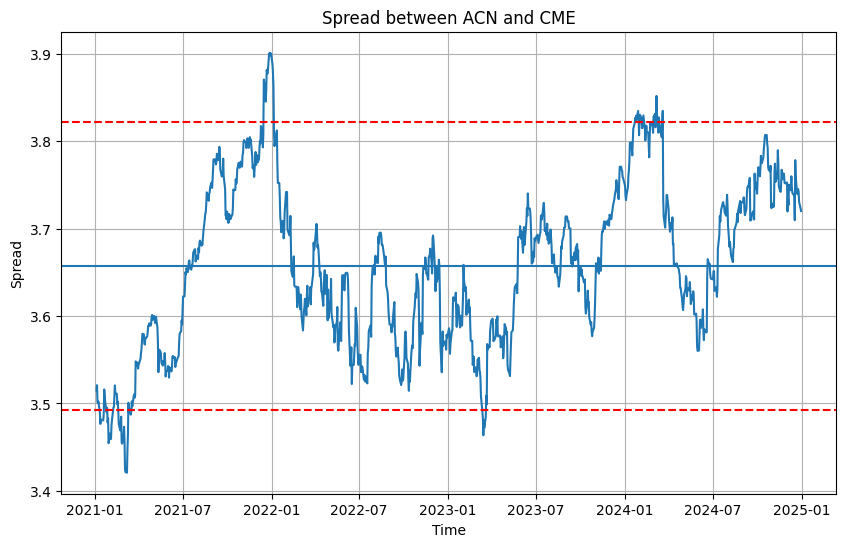

ValueError: Input y contains NaN.

In [ ]:
spread_calculator = Spread(data)
Pairs = spread_calculator.calculate_spread_and_volatility(Pair)

### Selection based on number of days holding trade

#### Another criteria I added in is that I want to hold this long-short pair and realize profit as quick as possible ideally. Hence, I would set a threshold of 60 days at most.

In [ ]:
Filtered_Pairs = Pairs[Pairs['Revert Time'] <60]

NameError: name 'Pairs' is not defined

In [ ]:
Filtered_Pairs

Ticker 1 Ticker 2  Volatility       Mean  90th Percentile  10th Percentile  \
1   2344.TW  6116.TW    0.177728   1.656791         1.967815         1.345767   
3   2385.TW  3706.TW    0.123838   2.961622         3.178338         2.744906   
6   6271.TW  8150.TW    0.219941   4.224035         4.608931         3.839139   
8   3231.TW  3380.TW    0.117779  -0.176105         0.030008        -0.382217   
10  2382.TW  6271.TW    0.430167  -7.578968        -6.826175        -8.331761   
19  2312.TW  2385.TW    0.695368 -15.350794       -14.133900       -16.567687   
23  8163.TW  2360.TW    0.575146 -11.132157       -10.125651       -12.138664   
24  2337.TW  2441.TW    0.240343  -1.177078        -0.756478        -1.597678   
25  2337.TW  2313.TW    0.197543   0.236077         0.581777        -0.109623   
26  2337.TW  2392.TW    0.267110   1.511575         1.979017         1.044133   
29  2337.TW  3711.TW    0.263578  -2.747528        -2.286266        -3.208790   

    Revert Time  
1     50.000000  
3     41.823529  
6     54.113636  
8     45.036364  
10    57.954545  
19    45.739130  
23    53.386364  
24    44.365385  
25    55.061224  
26    52.871795  
29    59.883721

### Calculate hedging ratio

In [ ]:
FPairs= Filtered_Pairs[['Ticker 1', 'Ticker 2']].apply(pd.Series)

In [ ]:
FPairs=FPairs[['Ticker 1', 'Ticker 2']]

In [ ]:
FPairs

Ticker 1 Ticker 2
1   2344.TW  6116.TW
3   2385.TW  3706.TW
6   6271.TW  8150.TW
8   3231.TW  3380.TW
10  2382.TW  6271.TW
19  2312.TW  2385.TW
23  8163.TW  2360.TW
24  2337.TW  2441.TW
25  2337.TW  2313.TW
26  2337.TW  2392.TW
29  2337.TW  3711.TW

In [ ]:
import Hedge


# Now you can use the reloaded Hedge_ratio class
hedge_ratio_instance = Hedge.Hedge_ratio(FPairs, merged_df)
HR = hedge_ratio_instance.hedge(FPairs, merged_df)

### Backtest with signal

#### Our signal will be when it hit the standard deviation then we will take position and unwind when it reaches the mean.

#### Assumption
1. Our price will be closing price
2. Not considering transaction cost
3. No borrowing cost consider might use SSF in TW to carry out this trade, assuming SSF same price and closing price

In [ ]:
%reload_ext autoreload

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3099, in _run_cell
    result = runner(coro)
             ^^^^^^^^^^^^
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3253, in run_cell_async
    self.history_manager.store_inputs(self.execution_count, cell, raw_cell)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\core\history.py", line 955, in store_inputs
    if self.save_flag:
       ^^^^^^^^^^^^^^
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\core\history.py", line 636, in save_flag
    return self.save_thread.save_flag
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'HistorySavingThread' object has no attri

In [ ]:
from Backtest import Backtest
Backtest = Backtest(FPairs,merged_df,HR)

[autoreload of peewee failed: Traceback (most recent call last):
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "C:\Users\taiji\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: '_Namespace' object layout differs from '_Namespace'
]


In [ ]:
!install pip pyfolio

ERROR: unknown command "pyfolio"



In [ ]:
for index, row in FPairs.iterrows():
    ticker1 = row[0]
    ticker2 = row[1]

    # Running the backtest process for each pair
    price_df = Backtest.position(ticker1, ticker2)
    portfolio = Backtest.cashflow(price_df)  # Calculate cashflow
    performance = Backtest.metric(price_df)  # Calculate performance metrics
    display(performance)
    Backtest.signal_plot(price_df, HR)

    # Save the results to CSV dynamically based on ticker names
    filename = f"{ticker1}_{ticker2}_results.csv"

    # Saving the portfolio DataFrame to CSV
    portfolio.to_csv(filename)
    print(f"Results saved for {ticker1} and {ticker2} to {filename}")


NameError: name 'Backtest' is not defined

#### **Preliminary Backtest's verdict**

Generally produce **good cumulative return**, **decent sharpe ratio** and **good tail ratio**. The main issue is the drawdown is huge mainly due to unrefined fixed position initiating approach. Whenever the spread threshold is reached, it initiates position limitlessly that lead to huge positions. When the spread widens, unrealized losses can be huge before spread reverts to mean. This might also be highly leveraged position.

#### Risk Management
1. Adaptive Position Sizing (Volatility-Based) + Scaling Position with Z score
2. Cap leverage and stop loss

## Position Sizing & Stop Loss

### **Adaptive Sizing Based on Volatility and Spread Scaling with Z-score**

An initial 5,000,000 NTD funding for each potential pair. Previously, we initiated fixed position as long as spread is greater than 2 standard-devation from mean. Using standard deviation approach might be clear cut but when volatility kicks in might lead to unstable performance. Hence, our position size might need to vary with the spread volatilty. In addition, we our position size to base 5% of leverage fund (2:1).

### **Z-Score Scaling for Position Sizing**
The Z-score is calculated as:
\[
Z_t = \frac{\text{Spread}_t - \mu}{\sigma}
\]

where:
- $( Z_t $) is the Z-score at time $(t)$,
- $\( \text{Spread}_t \)$ is the spread value at time $( t)$,
- $( \mu )$ is the mean of the spread (full history),
- $( \sigma )$ is the standard deviation of the spread.
#### **Position Sizing Based on Z-Score**
To scale position size dynamically based on the Z-score:
$[
\text{Position Size}_t = \text{Base Position} \times \min\left( 1 + k \times |Z_t|, \text{Max Scaling Factor} \right)
]$
where:
- $( k )$ is a scaling factor (determined by backtesting or risk management),
- $( \text{Max Scaling Factor} )$ caps the maximum position size to prevent excessive exposure.
If using a step function:
\[
\text{Position Size}_t =
\begin{cases}
1.0, & 2<|Z_t| < 2.5 \\
1.2, & 2.5 \leq |Z_t| < 3 \\
\end{cases}

### **Volatility-Based Position Multiplier for Spread Trading**
The idea of volatility adaptive sizing is to dynamically adjust position based on rolling standard deviation of the mean. The objective is to normalize risk exposure by taking larger position when volatility is low and smaller position when volatility is high.

The **position multiplier** is defined as:
$[
\text{Position Multiplier}_t = \frac{\sigma_{\text{mean}}}{\sigma_t}
]$
where:
- $\sigma_{\text{mean}}$ is the desired (normalized) volatility level for the strategy.
- $\sigma_t$ is the realized or rolling standard deviation of the spread at time $t$.
Thus, the **position size** is adjusted dynamically using:
$[
\text{Position Size}_t = \text{Base Position} \times \frac{\sigma_{\text{target}}}{\sigma_t}
]$
#### **Rolling Volatility Estimation**
The realized volatility $( \sigma_t)$ is computed using a rolling window $N$:
$\sigma_t = \sqrt{\frac{1}{N} \sum_{i=t-N}^{t} (S_i - \bar{S})^2}$
where:
- $S_i$ is the spread value at time $i$.
- $( \bar{S} )$ is the mean.
#### **Cap for total position**
$2<|Z_t| < 2.5 - text{lesser than 85% of leveraged fund}$
$2.5<|Z_t| < 3: - text{lesser than 15% of leveraged fund}$

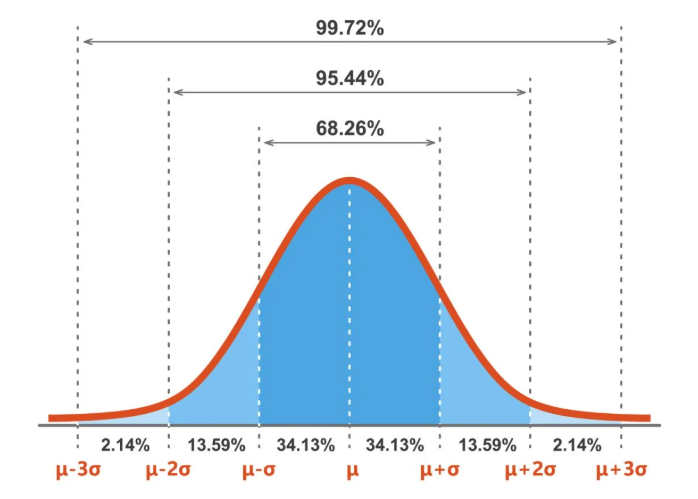

In [ ]:
Image(filename="./Z-Score_Distribution.PNG")

## Backtest with SL and Position Sizing

In [ ]:
from Backtest_SL_Dynamic import Strategy
Strategy =  Strategy(FPairs,merged_df,HR)

2344.TW    Spread Signal  Volatility Mutiplier    K    6116.TW  \
Date                                                                           
2017-01-03   7.772441 -3.464082    Buy                   NaN  1.2   6.160337   
2017-01-04   7.811111 -3.443989    Buy                   NaN  1.2   6.175815   
2017-01-05   7.888449 -3.439024    Buy                   NaN  1.2   6.276424   
2017-01-06   7.811111 -3.494477    Buy                   NaN  1.2   6.276424   
2017-01-09   7.733775 -3.634106    Buy                   NaN  1.2   6.446685   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  19.122204 -0.236704    NaN              8.412515  0.0  11.100000   
2022-12-27  19.170010 -0.236693    NaN              7.693626  0.0  11.150000   
2022-12-28  18.596344 -0.365378    NaN              6.584824  0.0  11.000000   
2022-12-29  18.596344 -0.435591    NaN              5.836944  0.0  11.250000   
2022-12-30  18.739759 -0.364455    NaN              5.719739  0.0  11.150000   

            2344.TW's trade  6116.TW's trade  2344.TW's position  \
Date                                                               
2017-01-03          43064.0         -43064.0             43064.0   
2017-01-04          39728.0         -39728.0             82792.0   
2017-01-05          36315.0         -36315.0            119107.0   
2017-01-06          33762.0         -33762.0            152869.0   
2017-01-09          31129.0         -31129.0            183998.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0                 0.0   
2022-12-27              0.0              0.0                 0.0   
2022-12-28              0.0              0.0                 0.0   
2022-12-29              0.0              0.0                 0.0   
2022-12-30              0.0              0.0                 0.0   

            6116.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03            -43064.0  4.930576e+06  0.108488               1.0   
2017-01-04            -82792.0  4.865609e+06  0.192244               2.0   
2017-01-05           -119107.0  4.807069e+06  0.259791               3.0   
2017-01-06           -152869.0  4.755255e+06  0.311711               4.0   
2017-01-09           -183998.0  4.715189e+06  0.356232               5.0   
...                        ...           ...       ...               ...   
2022-12-26                 0.0  8.255210e+06  1.000000              63.0   
2022-12-27                 0.0  8.255210e+06  1.000000              63.0   
2022-12-28                 0.0  8.255210e+06  1.000000              63.0   
2022-12-29                 0.0  8.255210e+06  1.000000              63.0   
2022-12-30                 0.0  8.255210e+06  1.000000              63.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       5.000999e+06  
2017-01-05  Initiated       4.999072e+06  
2017-01-06  Initiated       4.989861e+06  
2017-01-09  Initiated       4.952011e+06  
...               ...                ...  
2022-12-26     Closed       8.255210e+06  
2022-12-27     Closed       8.255210e+06  
2022-12-28     Closed       8.255210e+06  
2022-12-29     Closed       8.255210e+06  
2022-12-30     Closed       8.255210e+06  

[1556 rows x 15 columns]

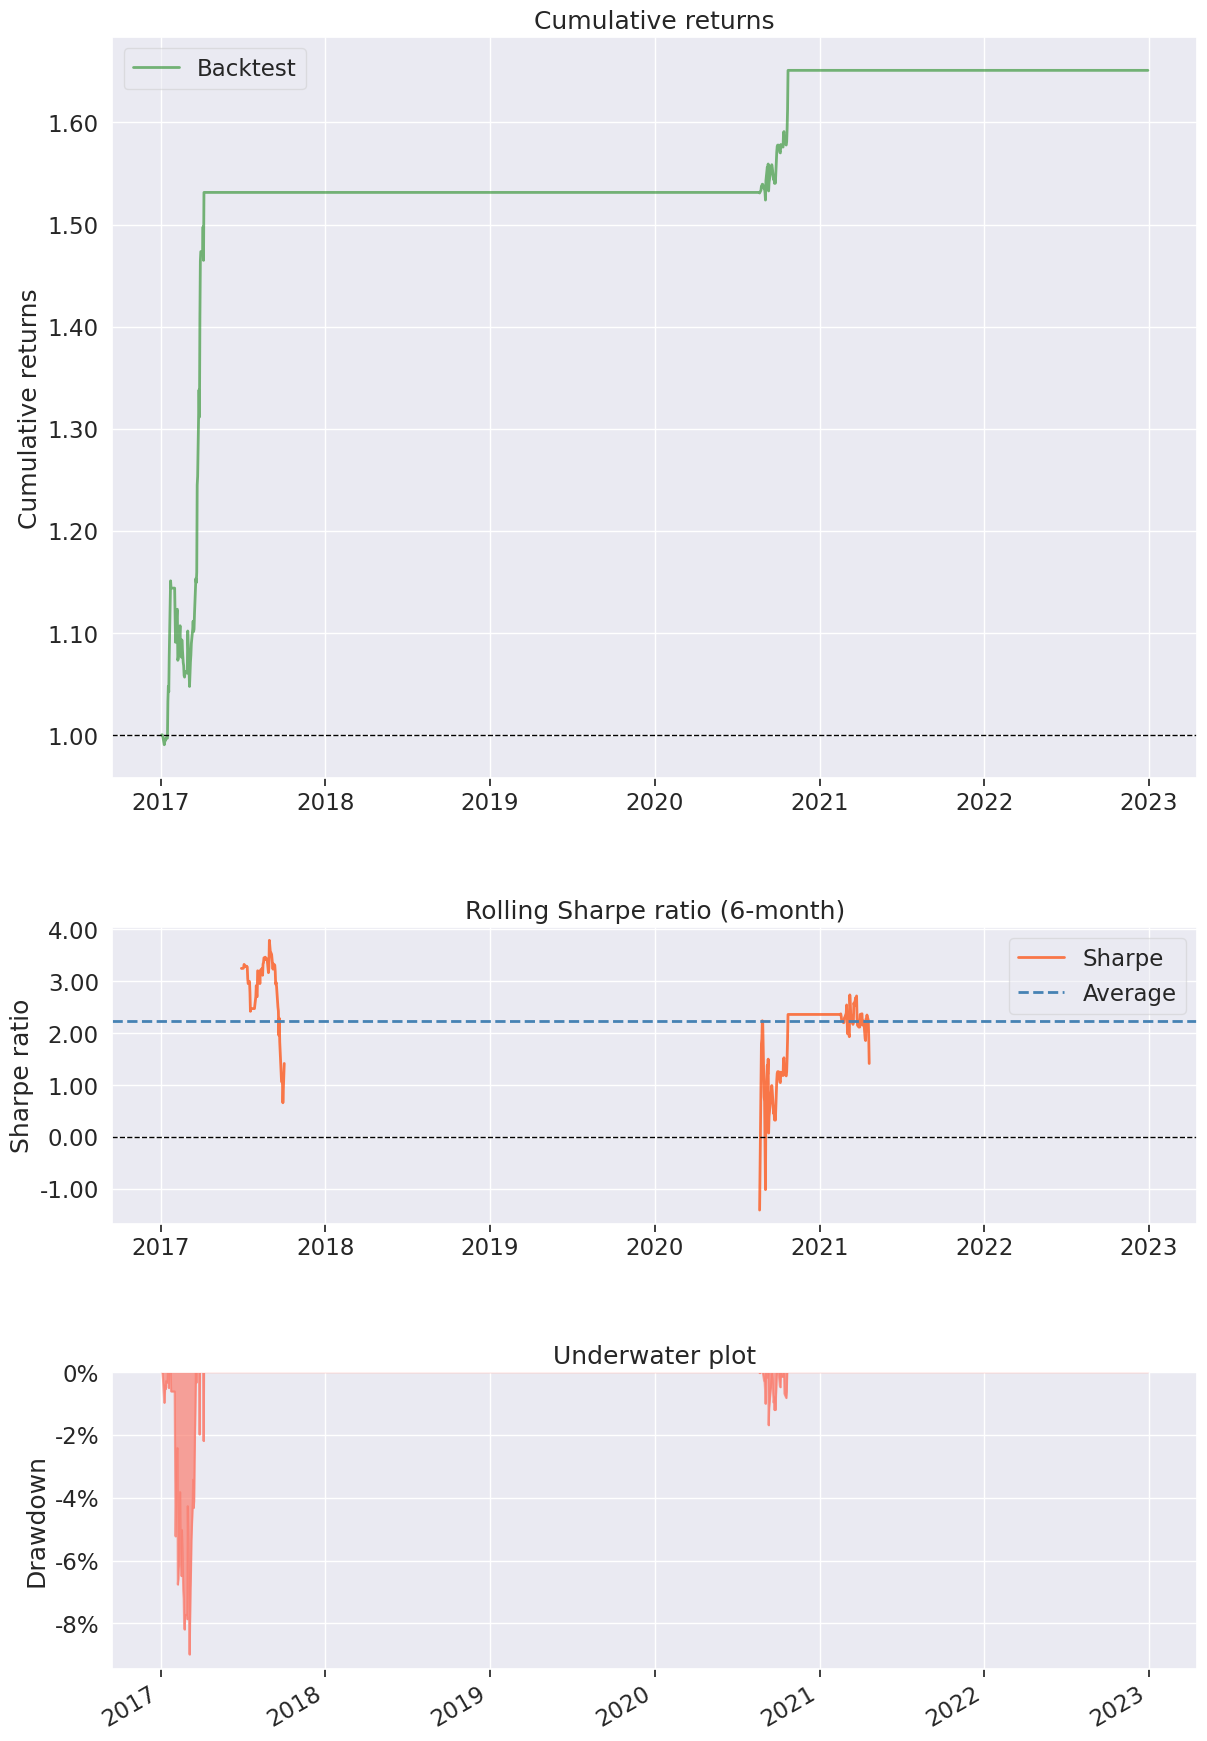

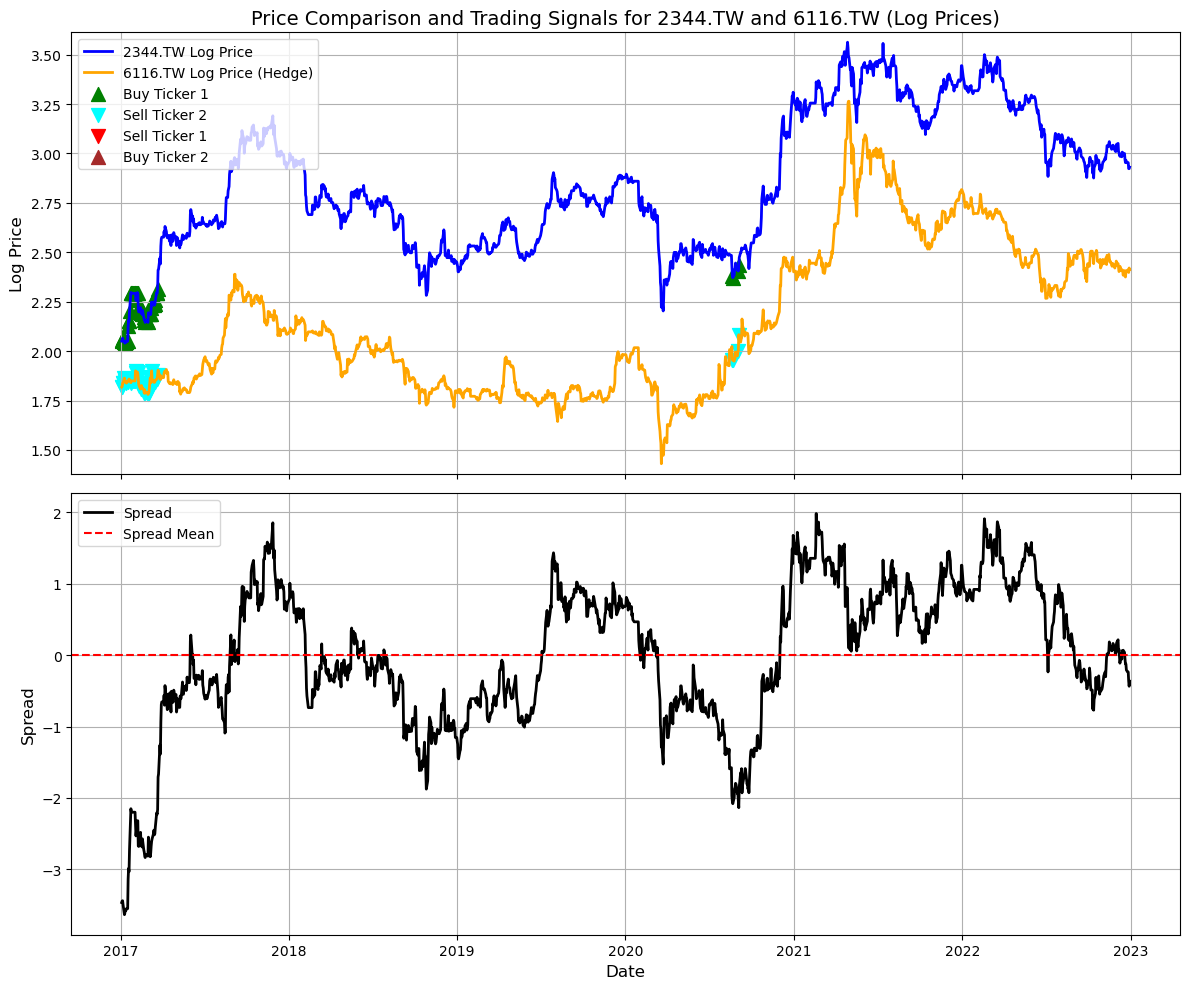

Results saved for 2344.TW and 6116.TW to 2344.TW_6116.TW_results.csv


2385.TW    Spread Signal  Volatility Mutiplier    K    3706.TW  \
Date                                                                           
2017-01-03  45.554295 -0.906003    NaN                   NaN  0.0  14.396782   
2017-01-04  45.432167 -1.021354    NaN                   NaN  0.0  14.863448   
2017-01-05  45.554295 -1.004275    NaN                   NaN  0.0  14.886786   
2017-01-06  45.065781 -1.091367    NaN                   NaN  0.0  14.886786   
2017-01-09  44.882587 -1.115050    NaN                   NaN  0.0  14.840117   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  77.092010  1.437452    NaN              7.142623  0.0  27.555494   
2022-12-27  77.002884  1.423144    NaN              7.424764  0.0  27.602123   
2022-12-28  76.557266  1.421243    NaN              7.710853  0.0  27.182493   
2022-12-29  76.824631  1.394520    NaN              8.359192  0.0  27.695374   
2022-12-30  76.913765  1.423726    NaN              9.216478  0.0  27.508871   

            2385.TW's trade  3706.TW's trade  2385.TW's position  \
Date                                                               
2017-01-03              0.0              0.0                 0.0   
2017-01-04              0.0              0.0                 0.0   
2017-01-05              0.0              0.0                 0.0   
2017-01-06              0.0              0.0                 0.0   
2017-01-09              0.0              0.0                 0.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0                 0.0   
2022-12-27              0.0              0.0                 0.0   
2022-12-28              0.0              0.0                 0.0   
2022-12-29              0.0              0.0                 0.0   
2022-12-30              0.0              0.0                 0.0   

            3706.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03                 0.0  5.000000e+06       1.0               0.0   
2017-01-04                 0.0  5.000000e+06       1.0               0.0   
2017-01-05                 0.0  5.000000e+06       1.0               0.0   
2017-01-06                 0.0  5.000000e+06       1.0               0.0   
2017-01-09                 0.0  5.000000e+06       1.0               0.0   
...                        ...           ...       ...               ...   
2022-12-26                 0.0  5.823184e+06       1.0              18.0   
2022-12-27                 0.0  5.823184e+06       1.0              18.0   
2022-12-28                 0.0  5.823184e+06       1.0              18.0   
2022-12-29                 0.0  5.823184e+06       1.0              18.0   
2022-12-30                 0.0  5.823184e+06       1.0              18.0   

            Status  Portfolio's Value  
Date                                   
2017-01-03  Closed       5.000000e+06  
2017-01-04  Closed       5.000000e+06  
2017-01-05  Closed       5.000000e+06  
2017-01-06  Closed       5.000000e+06  
2017-01-09  Closed       5.000000e+06  
...            ...                ...  
2022-12-26  Closed       5.823184e+06  
2022-12-27  Closed       5.823184e+06  
2022-12-28  Closed       5.823184e+06  
2022-12-29  Closed       5.823184e+06  
2022-12-30  Closed       5.823184e+06  

[1556 rows x 15 columns]

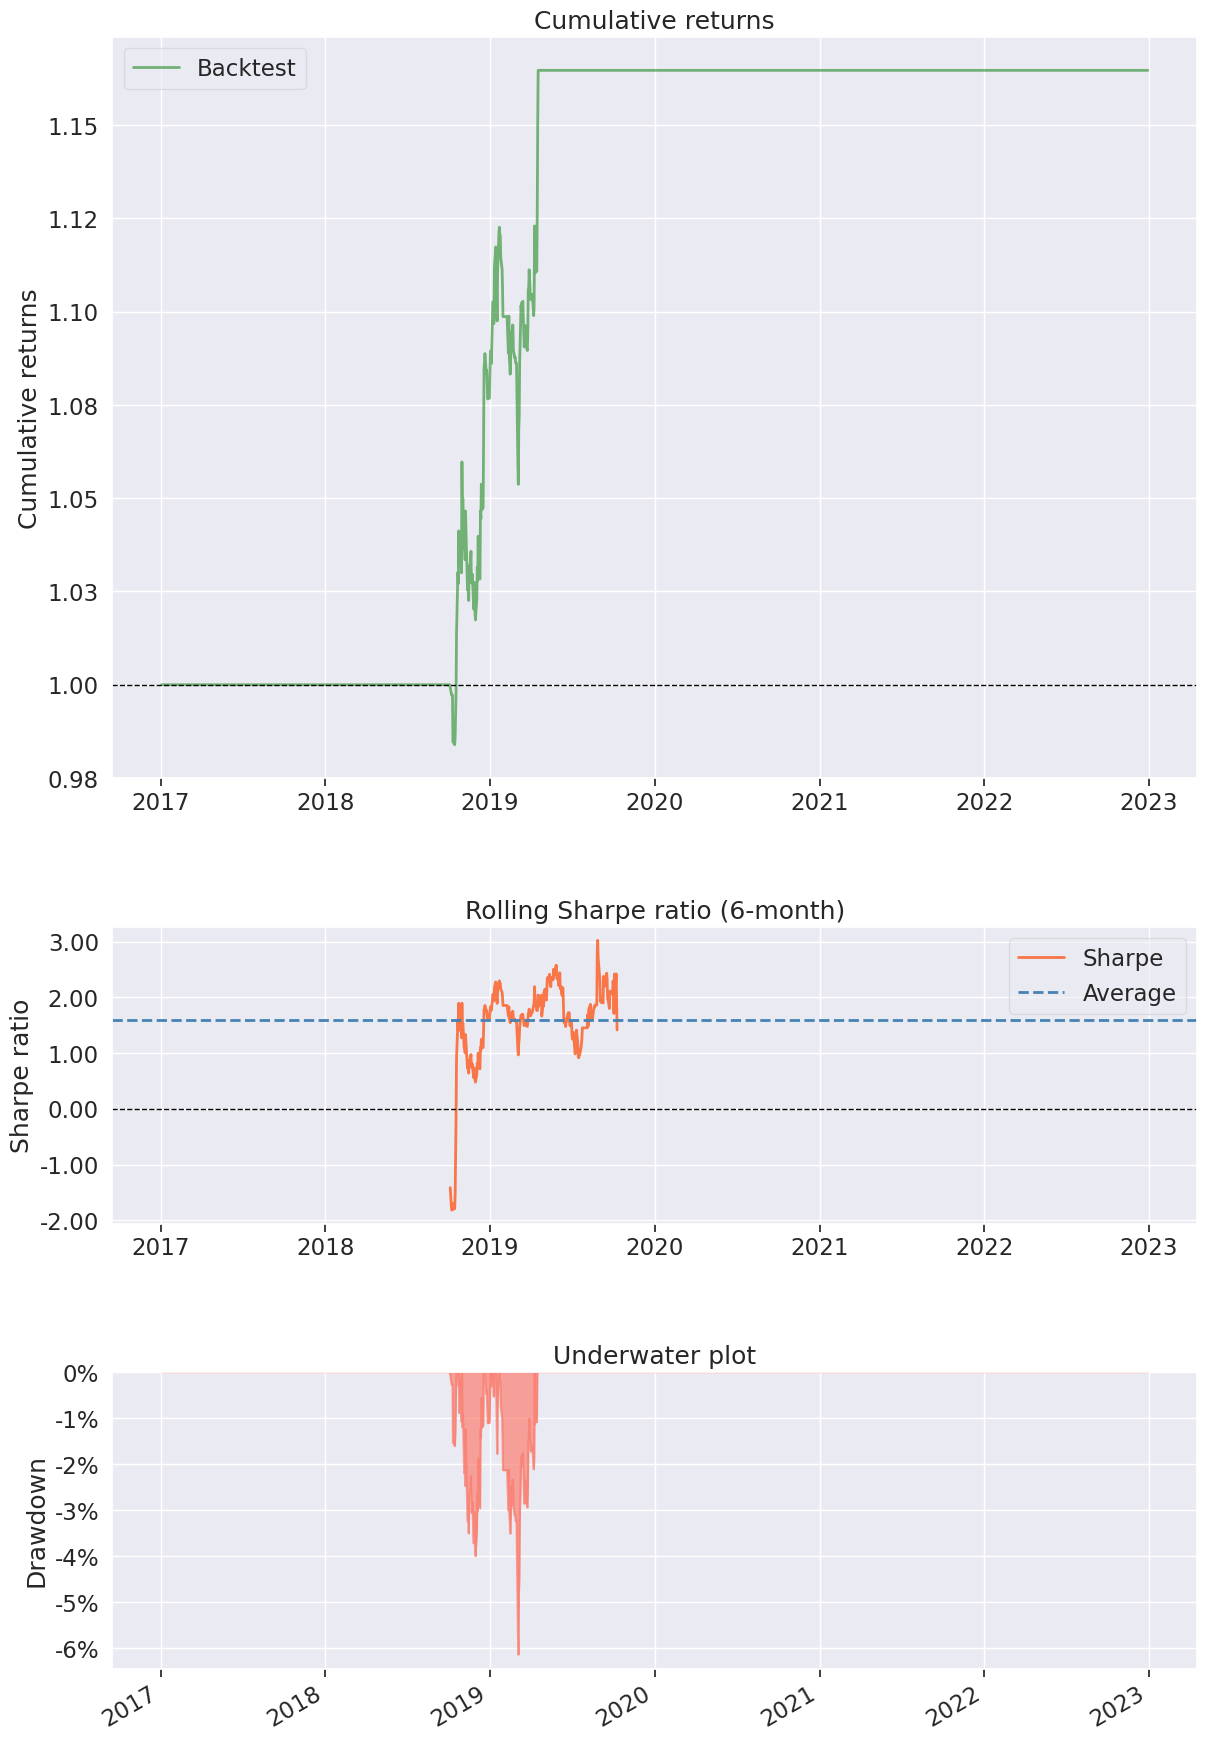

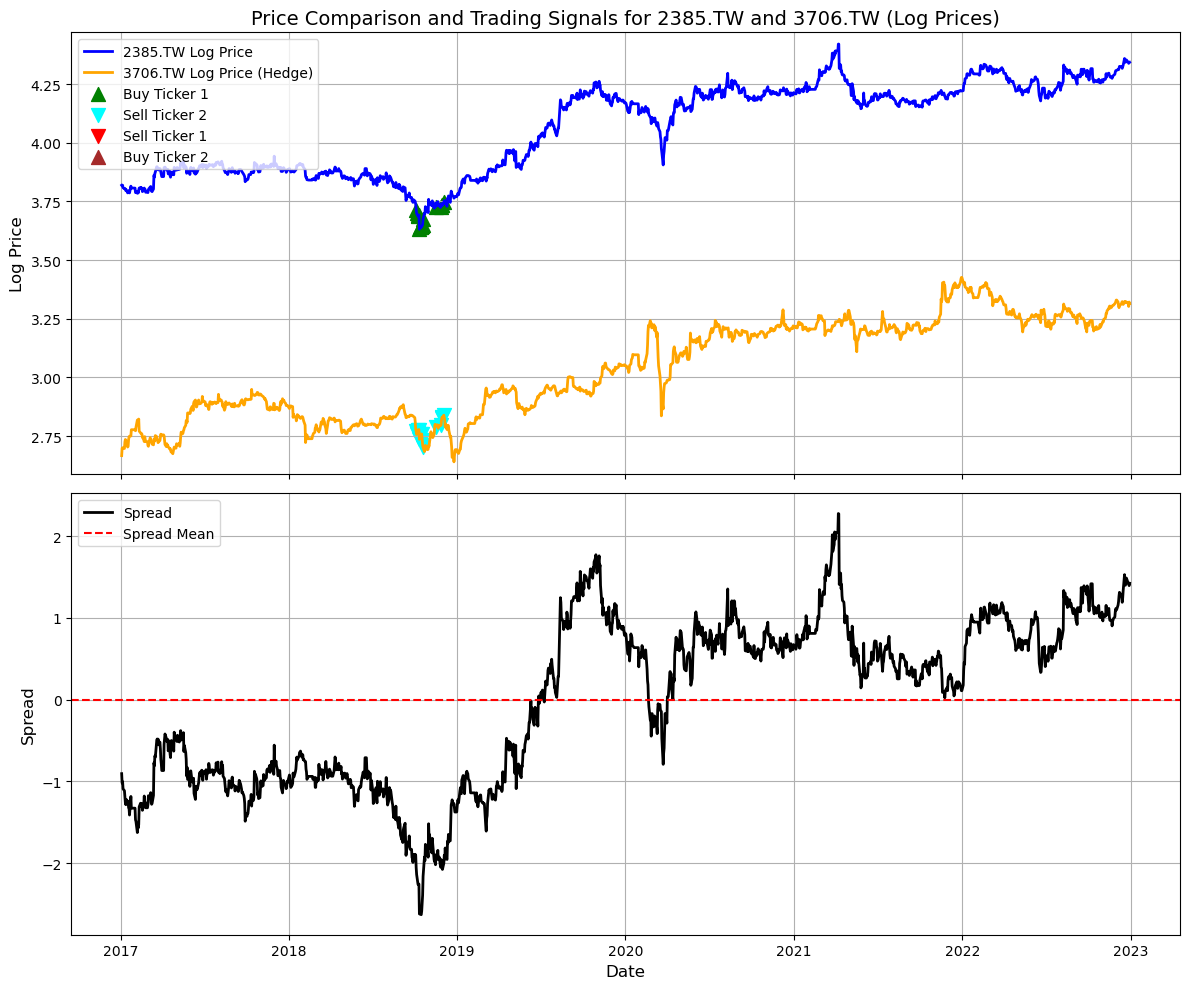

Results saved for 2385.TW and 3706.TW to 2385.TW_3706.TW_results.csv


6271.TW    Spread Signal  Volatility Mutiplier    K    8150.TW  \
Date                                                                            
2017-01-03   89.559746 -1.353741    NaN                   NaN  0.0  18.956896   
2017-01-04   92.036057 -1.215344    NaN                   NaN  0.0  18.649900   
2017-01-05   90.385178 -1.327882    NaN                   NaN  0.0  19.302265   
2017-01-06   90.385178 -1.362150    NaN                   NaN  0.0  20.069750   
2017-01-09   88.321587 -1.455350    NaN                   NaN  0.0  19.801128   
...                ...       ...    ...                   ...  ...        ...   
2022-12-26  145.065048  0.443242    NaN              6.079693  0.0  29.764128   
2022-12-27  146.515701  0.496536    NaN              5.848376  0.0  29.493134   
2022-12-28  139.987778  0.298715    NaN              5.205947  0.0  29.176973   
2022-12-29  139.262451  0.265616    NaN              4.729517  0.0  29.493134   
2022-12-30  138.537125  0.219279    NaN              4.337349  0.0  30.260948   

            6271.TW's trade  8150.TW's trade  6271.TW's position  \
Date                                                               
2017-01-03              0.0              0.0                 0.0   
2017-01-04              0.0              0.0                 0.0   
2017-01-05              0.0              0.0                 0.0   
2017-01-06              0.0              0.0                 0.0   
2017-01-09              0.0              0.0                 0.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0                 0.0   
2022-12-27              0.0              0.0                 0.0   
2022-12-28              0.0              0.0                 0.0   
2022-12-29              0.0              0.0                 0.0   
2022-12-30              0.0              0.0                 0.0   

            8150.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03                 0.0  5.000000e+06       1.0               0.0   
2017-01-04                 0.0  5.000000e+06       1.0               0.0   
2017-01-05                 0.0  5.000000e+06       1.0               0.0   
2017-01-06                 0.0  5.000000e+06       1.0               0.0   
2017-01-09                 0.0  5.000000e+06       1.0               0.0   
...                        ...           ...       ...               ...   
2022-12-26                 0.0  6.393468e+06       1.0              20.0   
2022-12-27                 0.0  6.393468e+06       1.0              20.0   
2022-12-28                 0.0  6.393468e+06       1.0              20.0   
2022-12-29                 0.0  6.393468e+06       1.0              20.0   
2022-12-30                 0.0  6.393468e+06       1.0              20.0   

            Status  Portfolio's Value  
Date                                   
2017-01-03  Closed       5.000000e+06  
2017-01-04  Closed       5.000000e+06  
2017-01-05  Closed       5.000000e+06  
2017-01-06  Closed       5.000000e+06  
2017-01-09  Closed       5.000000e+06  
...            ...                ...  
2022-12-26  Closed       6.393468e+06  
2022-12-27  Closed       6.393468e+06  
2022-12-28  Closed       6.393468e+06  
2022-12-29  Closed       6.393468e+06  
2022-12-30  Closed       6.393468e+06  

[1556 rows x 15 columns]

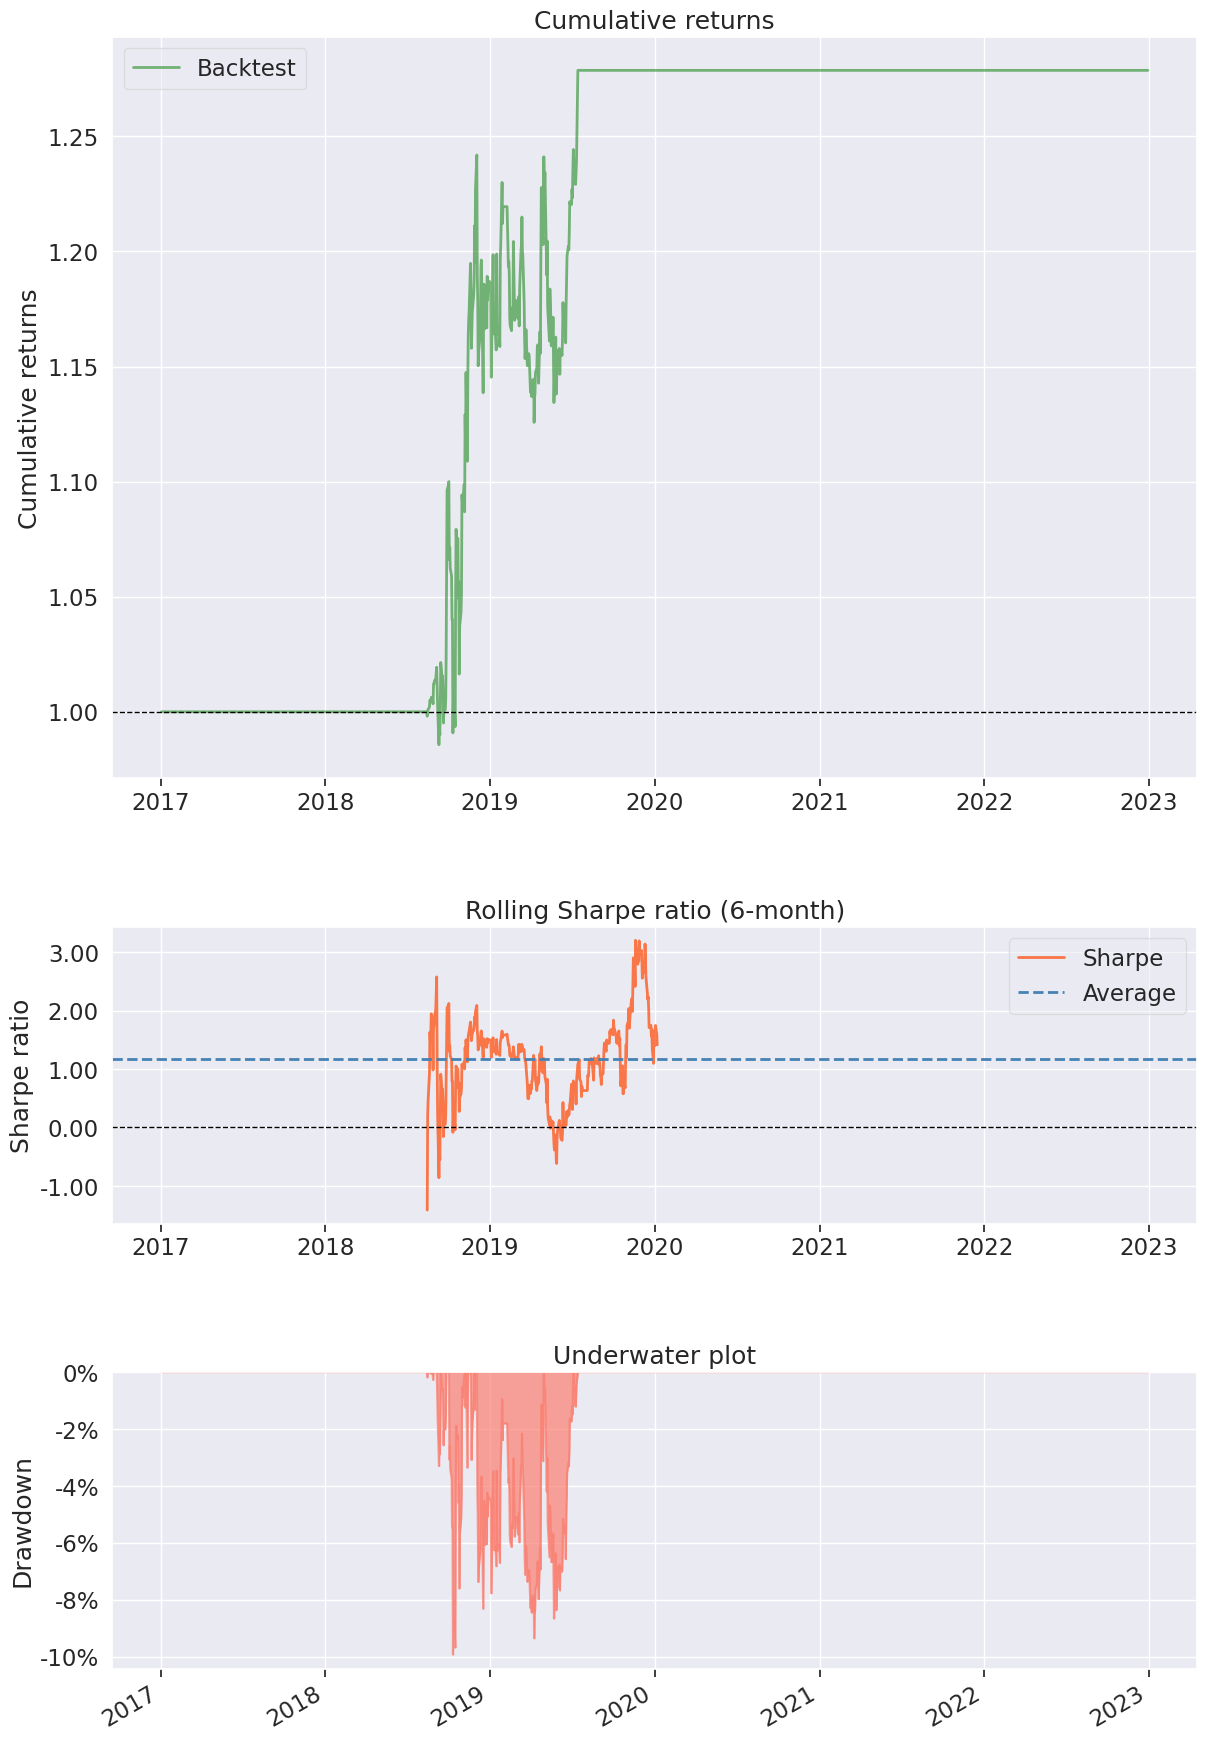

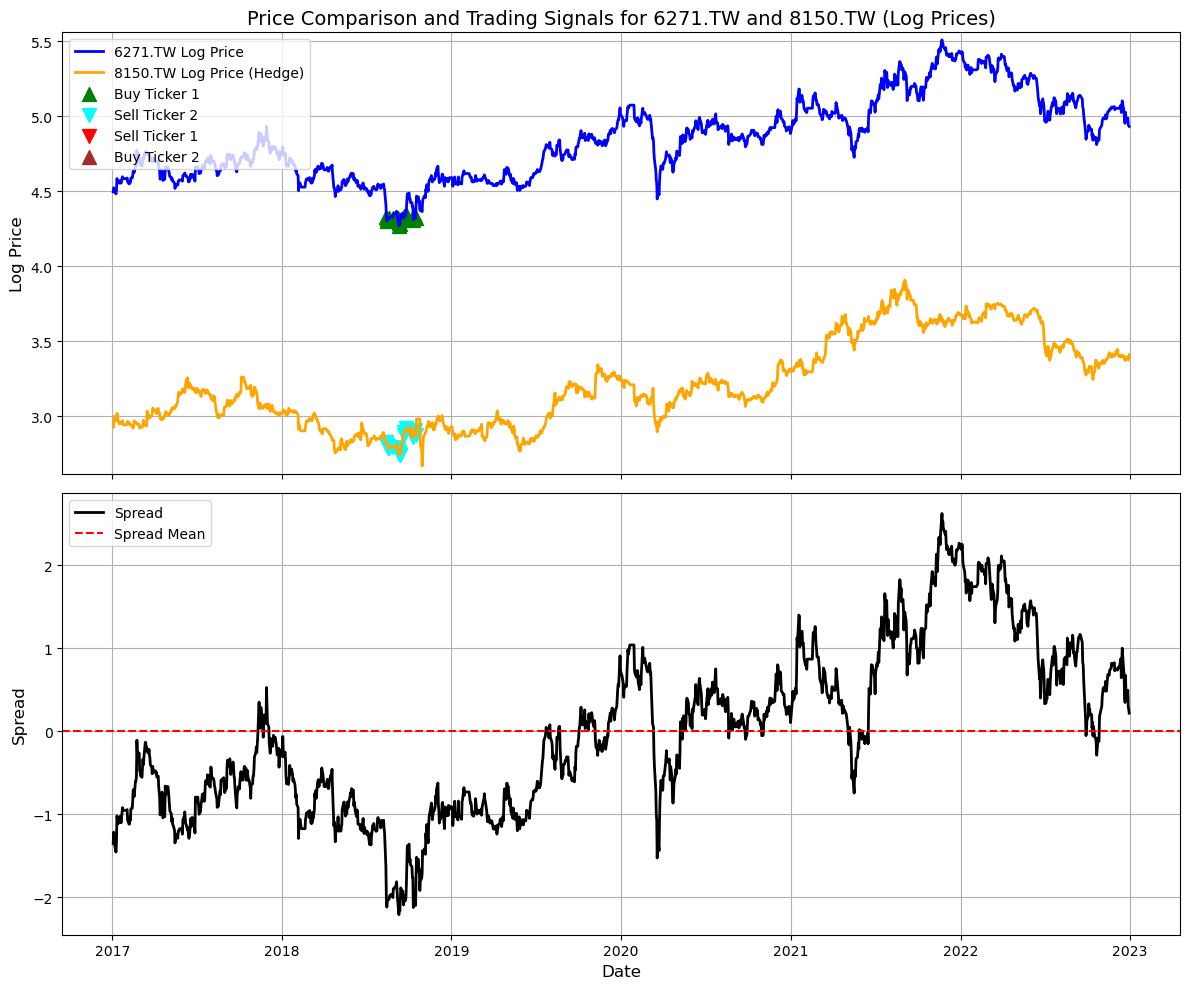

Results saved for 6271.TW and 8150.TW to 6271.TW_8150.TW_results.csv


3231.TW    Spread Signal  Volatility Mutiplier    K    3380.TW  \
Date                                                                           
2017-01-03  15.547923  0.616989    NaN                   NaN  0.0  14.974222   
2017-01-04  15.392446  0.442715    NaN                   NaN  0.0  15.123964   
2017-01-05  15.205872  0.163918    NaN                   NaN  0.0  15.423450   
2017-01-06  15.610117  0.430245    NaN                   NaN  0.0  15.348577   
2017-01-09  15.547923  0.639357    NaN                   NaN  0.0  14.936787   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  28.232948  0.522406    NaN              1.578436  0.0  26.680269   
2022-12-27  28.280560  0.381034    NaN              1.579563  0.0  27.149168   
2022-12-28  27.899673  0.516279    NaN              1.566581  0.0  26.398932   
2022-12-29  28.042507  0.575536    NaN              1.586380  0.0  26.352041   
2022-12-30  27.994896  0.529359    NaN              1.627271  0.0  26.445822   

            3231.TW's trade  3380.TW's trade  3231.TW's position  \
Date                                                               
2017-01-03              0.0              0.0                 0.0   
2017-01-04              0.0              0.0                 0.0   
2017-01-05              0.0              0.0                 0.0   
2017-01-06              0.0              0.0                 0.0   
2017-01-09              0.0              0.0                 0.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0           -186550.0   
2022-12-27              0.0              0.0           -186550.0   
2022-12-28              0.0              0.0           -186550.0   
2022-12-29              0.0              0.0           -186550.0   
2022-12-30              0.0              0.0           -186550.0   

            3380.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03                 0.0  5.000000e+06  1.000000               0.0   
2017-01-04                 0.0  5.000000e+06  1.000000               0.0   
2017-01-05                 0.0  5.000000e+06  1.000000               0.0   
2017-01-06                 0.0  5.000000e+06  1.000000               0.0   
2017-01-09                 0.0  5.000000e+06  1.000000               0.0   
...                        ...           ...       ...               ...   
2022-12-26            186550.0  6.251316e+06  1.638705              45.0   
2022-12-27            186550.0  6.251316e+06  1.654118              45.0   
2022-12-28            186550.0  6.251316e+06  1.620364              45.0   
2022-12-29            186550.0  6.251316e+06  1.623227              45.0   
2022-12-30            186550.0  6.251316e+06  1.624605              45.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03     Closed       5.000000e+06  
2017-01-04     Closed       5.000000e+06  
2017-01-05     Closed       5.000000e+06  
2017-01-06     Closed       5.000000e+06  
2017-01-09     Closed       5.000000e+06  
...               ...                ...  
2022-12-26  Initiated       5.961664e+06  
2022-12-27  Initiated       6.040255e+06  
2022-12-28  Initiated       5.971352e+06  
2022-12-29  Initiated       5.935959e+06  
2022-12-30  Initiated       5.962336e+06  

[1556 rows x 15 columns]

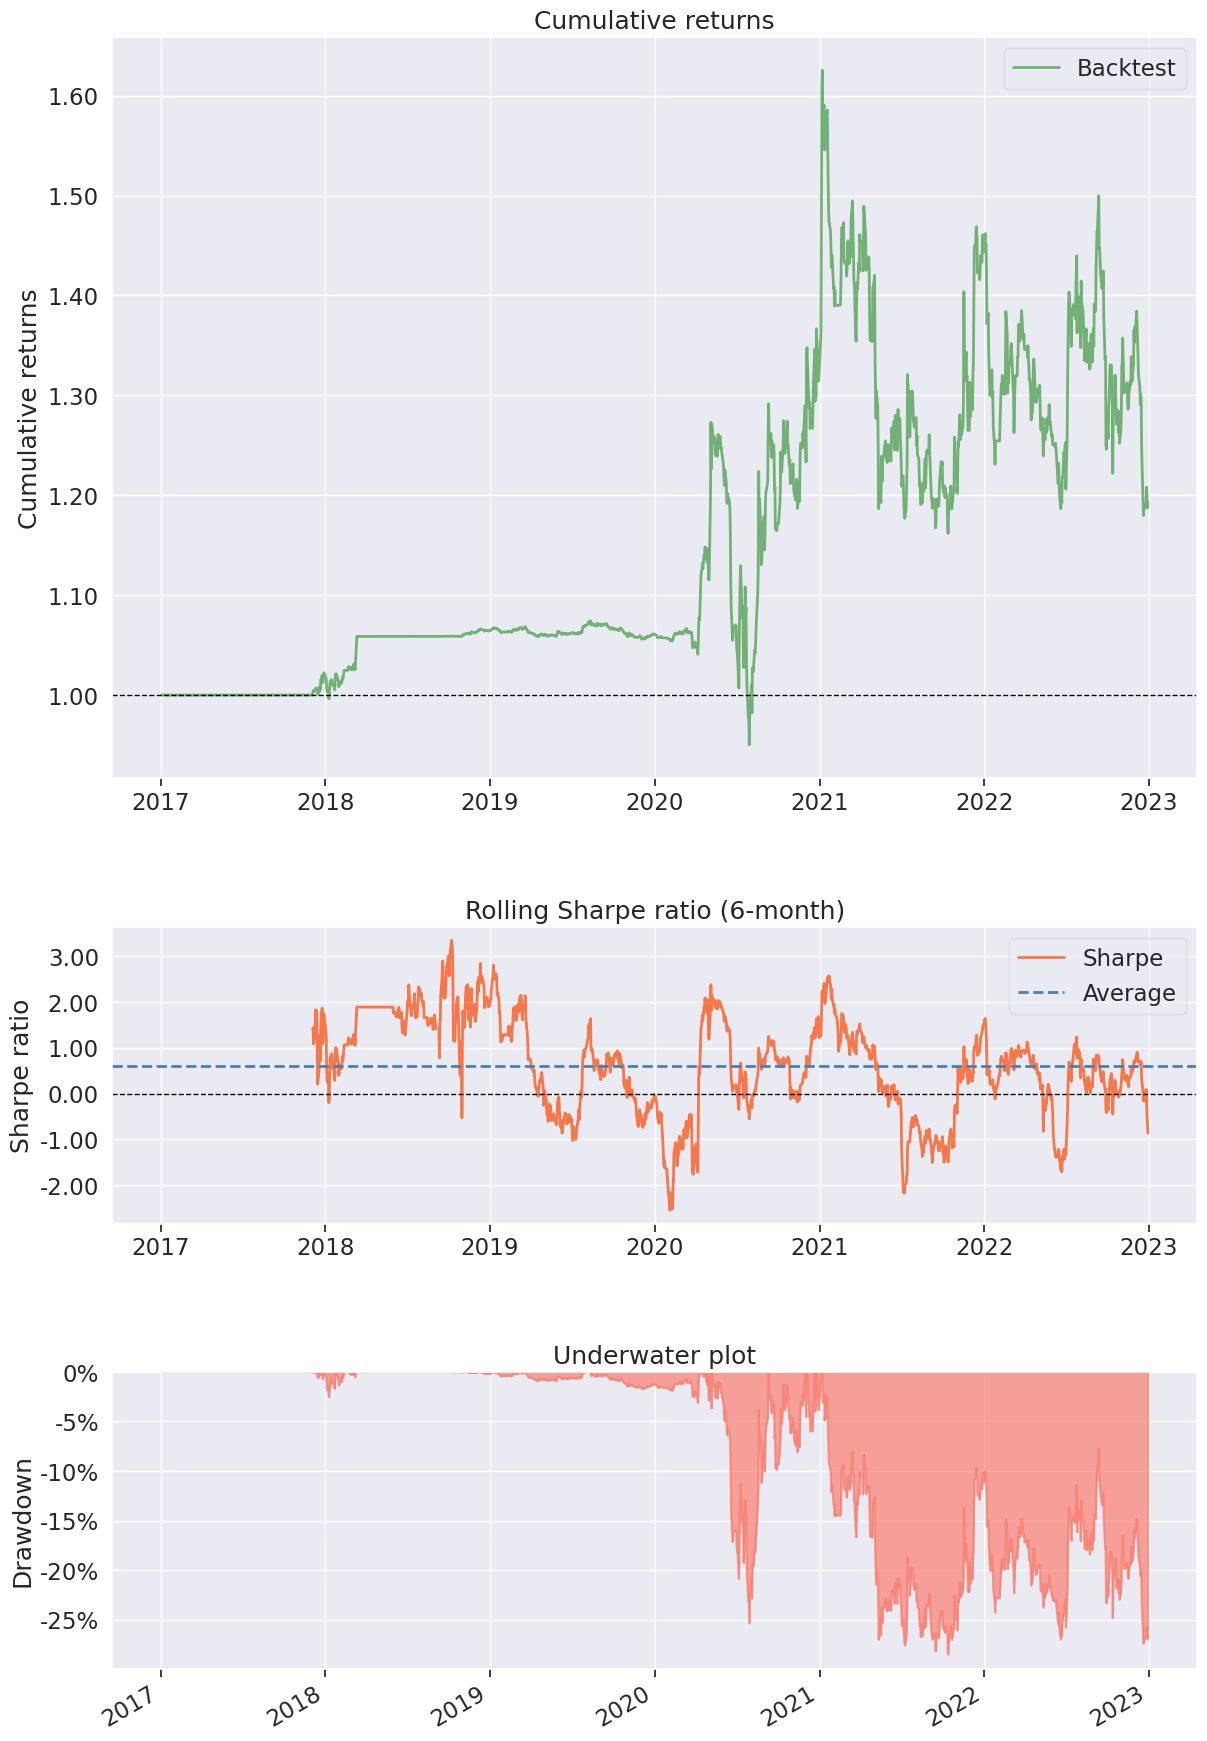

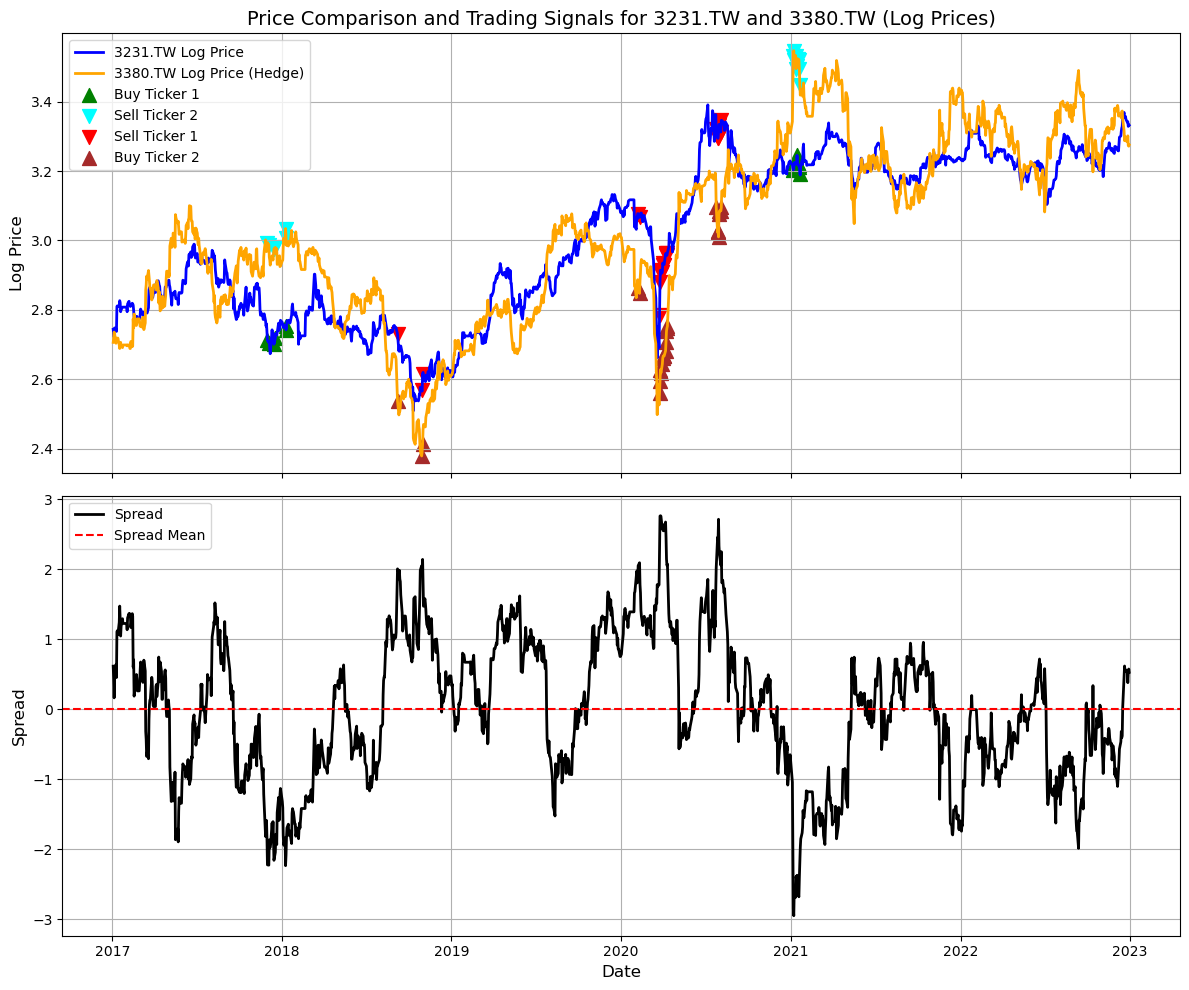

Results saved for 3231.TW and 3380.TW to 3231.TW_3380.TW_results.csv


2382.TW    Spread Signal  Volatility Mutiplier    K     6271.TW  \
Date                                                                            
2017-01-03  37.951729  1.254769    NaN                   NaN  0.0   89.559746   
2017-01-04  37.951729  1.104132    NaN                   NaN  0.0   92.036057   
2017-01-05  37.951729  1.204099    NaN                   NaN  0.0   90.385178   
2017-01-06  38.204739  1.219551    NaN                   NaN  0.0   90.385178   
2017-01-09  38.963776  1.392857    NaN                   NaN  0.0   88.321587   
...               ...       ...    ...                   ...  ...         ...   
2022-12-26  64.766739 -0.165973    NaN              5.203122  0.0  145.065048   
2022-12-27  64.766739 -0.220929    NaN              4.976974  0.0  146.515701   
2022-12-28  64.857071  0.034038    NaN              4.358653  0.0  139.987778   
2022-12-29  64.766739  0.059488    NaN              3.946650  0.0  139.262451   
2022-12-30  65.308723  0.107708    NaN              3.627031  0.0  138.537125   

            2382.TW's trade  6271.TW's trade  2382.TW's position  \
Date                                                               
2017-01-03              0.0              0.0                 0.0   
2017-01-04              0.0              0.0                 0.0   
2017-01-05              0.0              0.0                 0.0   
2017-01-06              0.0              0.0                 0.0   
2017-01-09              0.0              0.0                 0.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0          -7271824.0   
2022-12-27              0.0              0.0          -7271824.0   
2022-12-28              0.0              0.0          -7271824.0   
2022-12-29              0.0              0.0          -7271824.0   
2022-12-30              0.0              0.0          -7271824.0   

            6271.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03                 0.0  5.000000e+06       1.0               0.0   
2017-01-04                 0.0  5.000000e+06       1.0               0.0   
2017-01-05                 0.0  5.000000e+06       1.0               0.0   
2017-01-06                 0.0  5.000000e+06       1.0               0.0   
2017-01-09                 0.0  5.000000e+06       1.0               0.0   
...                        ...           ...       ...               ...   
2022-12-26           7271824.0 -1.053938e+09       1.0              94.0   
2022-12-27           7271824.0 -1.053938e+09       1.0              94.0   
2022-12-28           7271824.0 -1.053938e+09       1.0              94.0   
2022-12-29           7271824.0 -1.053938e+09       1.0              94.0   
2022-12-30           7271824.0 -1.053938e+09       1.0              94.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03     Closed       5.000000e+06  
2017-01-04     Closed       5.000000e+06  
2017-01-05     Closed       5.000000e+06  
2017-01-06     Closed       5.000000e+06  
2017-01-09     Closed       5.000000e+06  
...               ...                ...  
2022-12-26  Initiated      -4.700232e+08  
2022-12-27  Initiated      -4.594743e+08  
2022-12-28  Initiated      -5.076011e+08  
2022-12-29  Initiated      -5.122187e+08  
2022-12-30  Initiated      -5.214343e+08  

[1556 rows x 15 columns]

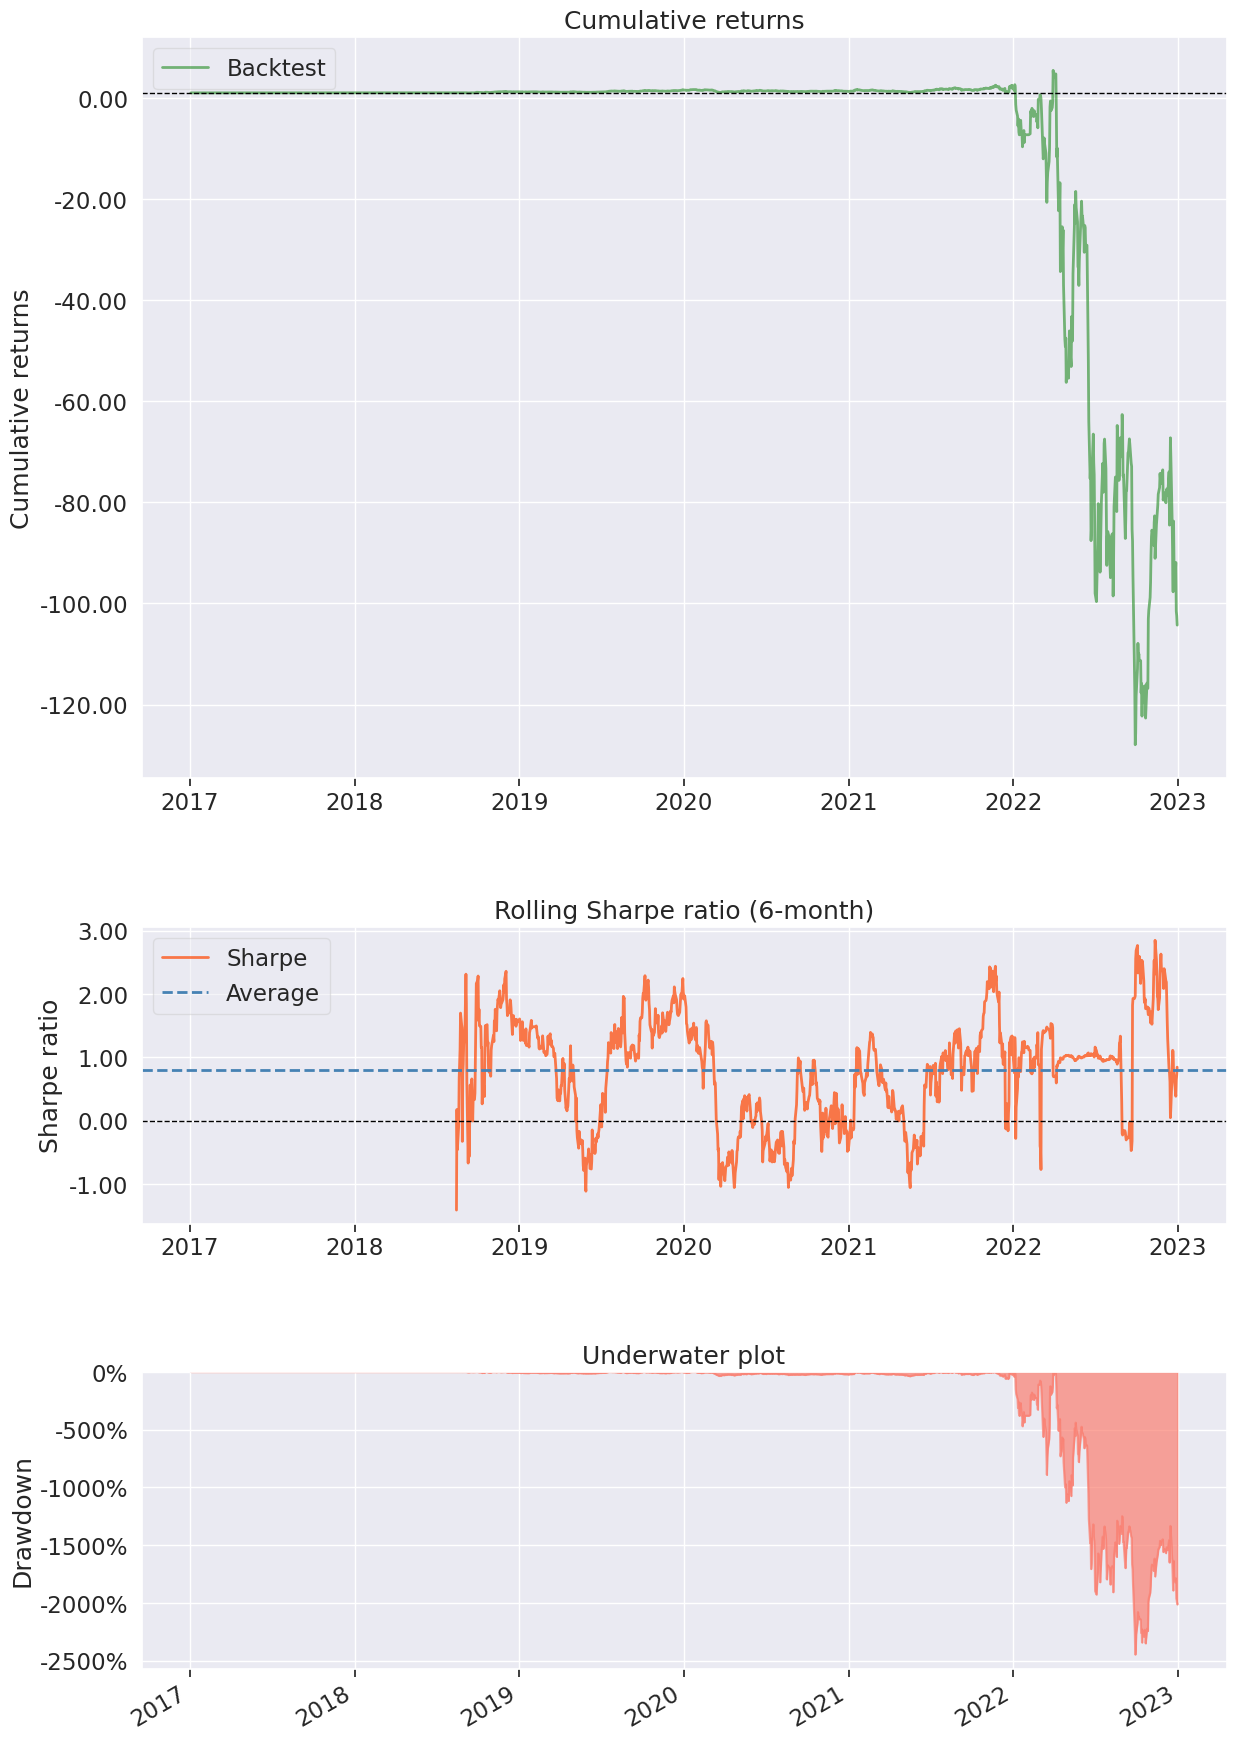

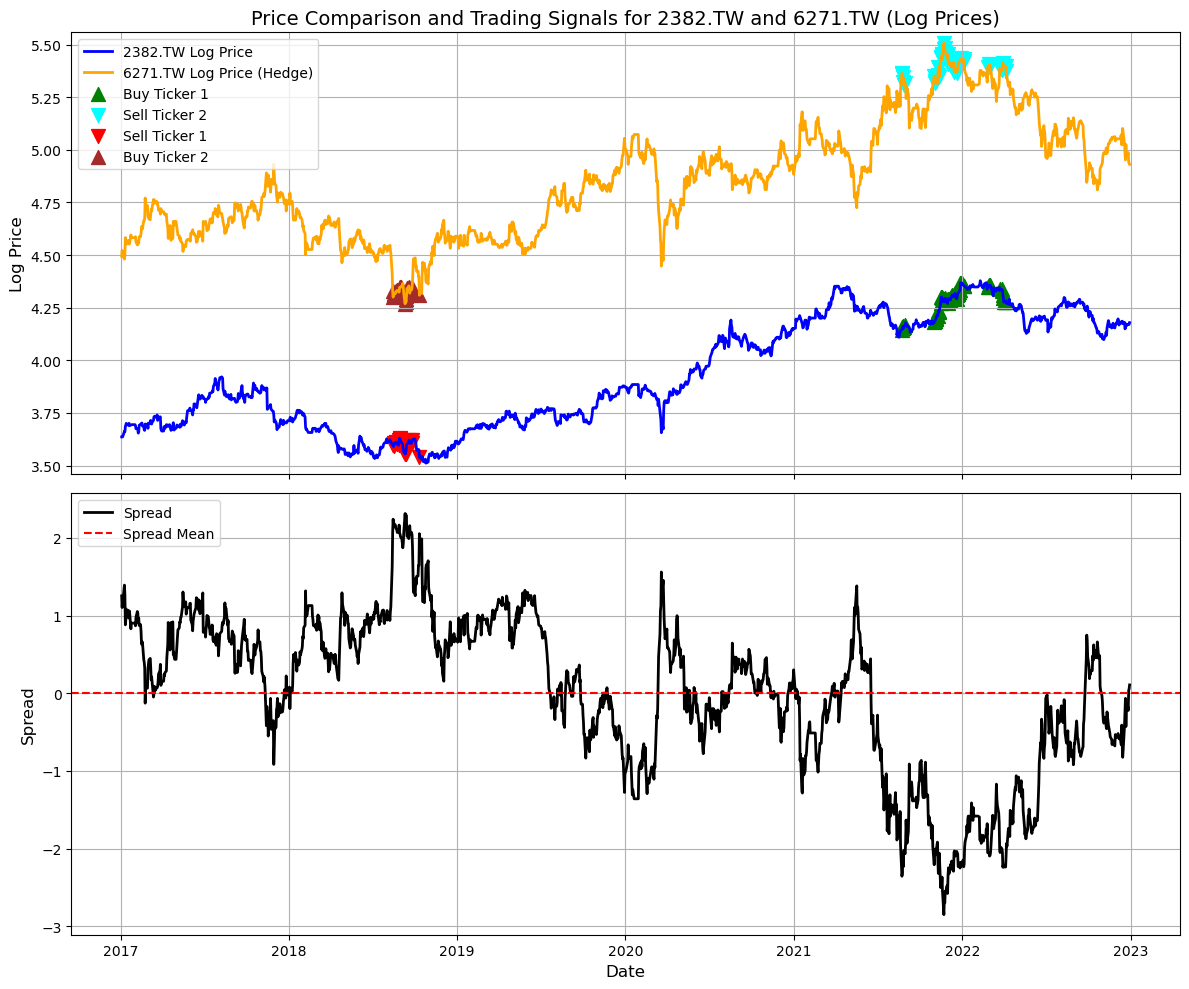

Results saved for 2382.TW and 6271.TW to 2382.TW_6271.TW_results.csv


2312.TW    Spread Signal  Volatility Mutiplier    K    2385.TW  \
Date                                                                           
2017-01-03   9.861103  1.445572    NaN                   NaN  0.0  45.554295   
2017-01-04   9.861103  1.462394    NaN                   NaN  0.0  45.432167   
2017-01-05  10.026141  1.469449    NaN                   NaN  0.0  45.554295   
2017-01-06  10.067402  1.542916    NaN                   NaN  0.0  45.065781   
2017-01-09  10.067402  1.568440    NaN                   NaN  0.0  44.882587   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  13.248311 -1.426218    NaN              7.817814  0.0  77.092010   
2022-12-27  13.248311 -1.418970    NaN              7.881661  0.0  77.002884   
2022-12-28  13.103785 -1.398382    NaN              7.944235  0.0  76.557266   
2022-12-29  12.959257 -1.436182    NaN              8.058307  0.0  76.824631   
2022-12-30  13.007434 -1.438110    NaN              8.394889  0.0  76.913765   

            2312.TW's trade  2385.TW's trade  2312.TW's position  \
Date                                                               
2017-01-03              0.0              0.0                 0.0   
2017-01-04              0.0              0.0                 0.0   
2017-01-05              0.0              0.0                 0.0   
2017-01-06              0.0              0.0                 0.0   
2017-01-09              0.0              0.0                 0.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0            -68521.0   
2022-12-27              0.0              0.0            -68521.0   
2022-12-28              0.0              0.0            -68521.0   
2022-12-29              0.0              0.0            -68521.0   
2022-12-30              0.0              0.0            -68521.0   

            2385.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03                 0.0  5.000000e+06  1.000000               0.0   
2017-01-04                 0.0  5.000000e+06  1.000000               0.0   
2017-01-05                 0.0  5.000000e+06  1.000000               0.0   
2017-01-06                 0.0  5.000000e+06  1.000000               0.0   
2017-01-09                 0.0  5.000000e+06  1.000000               0.0   
...                        ...           ...       ...               ...   
2022-12-26             68521.0  2.897658e+06  2.136280              13.0   
2022-12-27             68521.0  2.897658e+06  2.134173              13.0   
2022-12-28             68521.0  2.897658e+06  2.120217              13.0   
2022-12-29             68521.0  2.897658e+06  2.123122              13.0   
2022-12-30             68521.0  2.897658e+06  2.126369              13.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03     Closed       5.000000e+06  
2017-01-04     Closed       5.000000e+06  
2017-01-05     Closed       5.000000e+06  
2017-01-06     Closed       5.000000e+06  
2017-01-09     Closed       5.000000e+06  
...               ...                ...  
2022-12-26  Initiated       7.272292e+06  
2022-12-27  Initiated       7.266185e+06  
2022-12-28  Initiated       7.245554e+06  
2022-12-29  Initiated       7.273777e+06  
2022-12-30  Initiated       7.276584e+06  

[1556 rows x 15 columns]

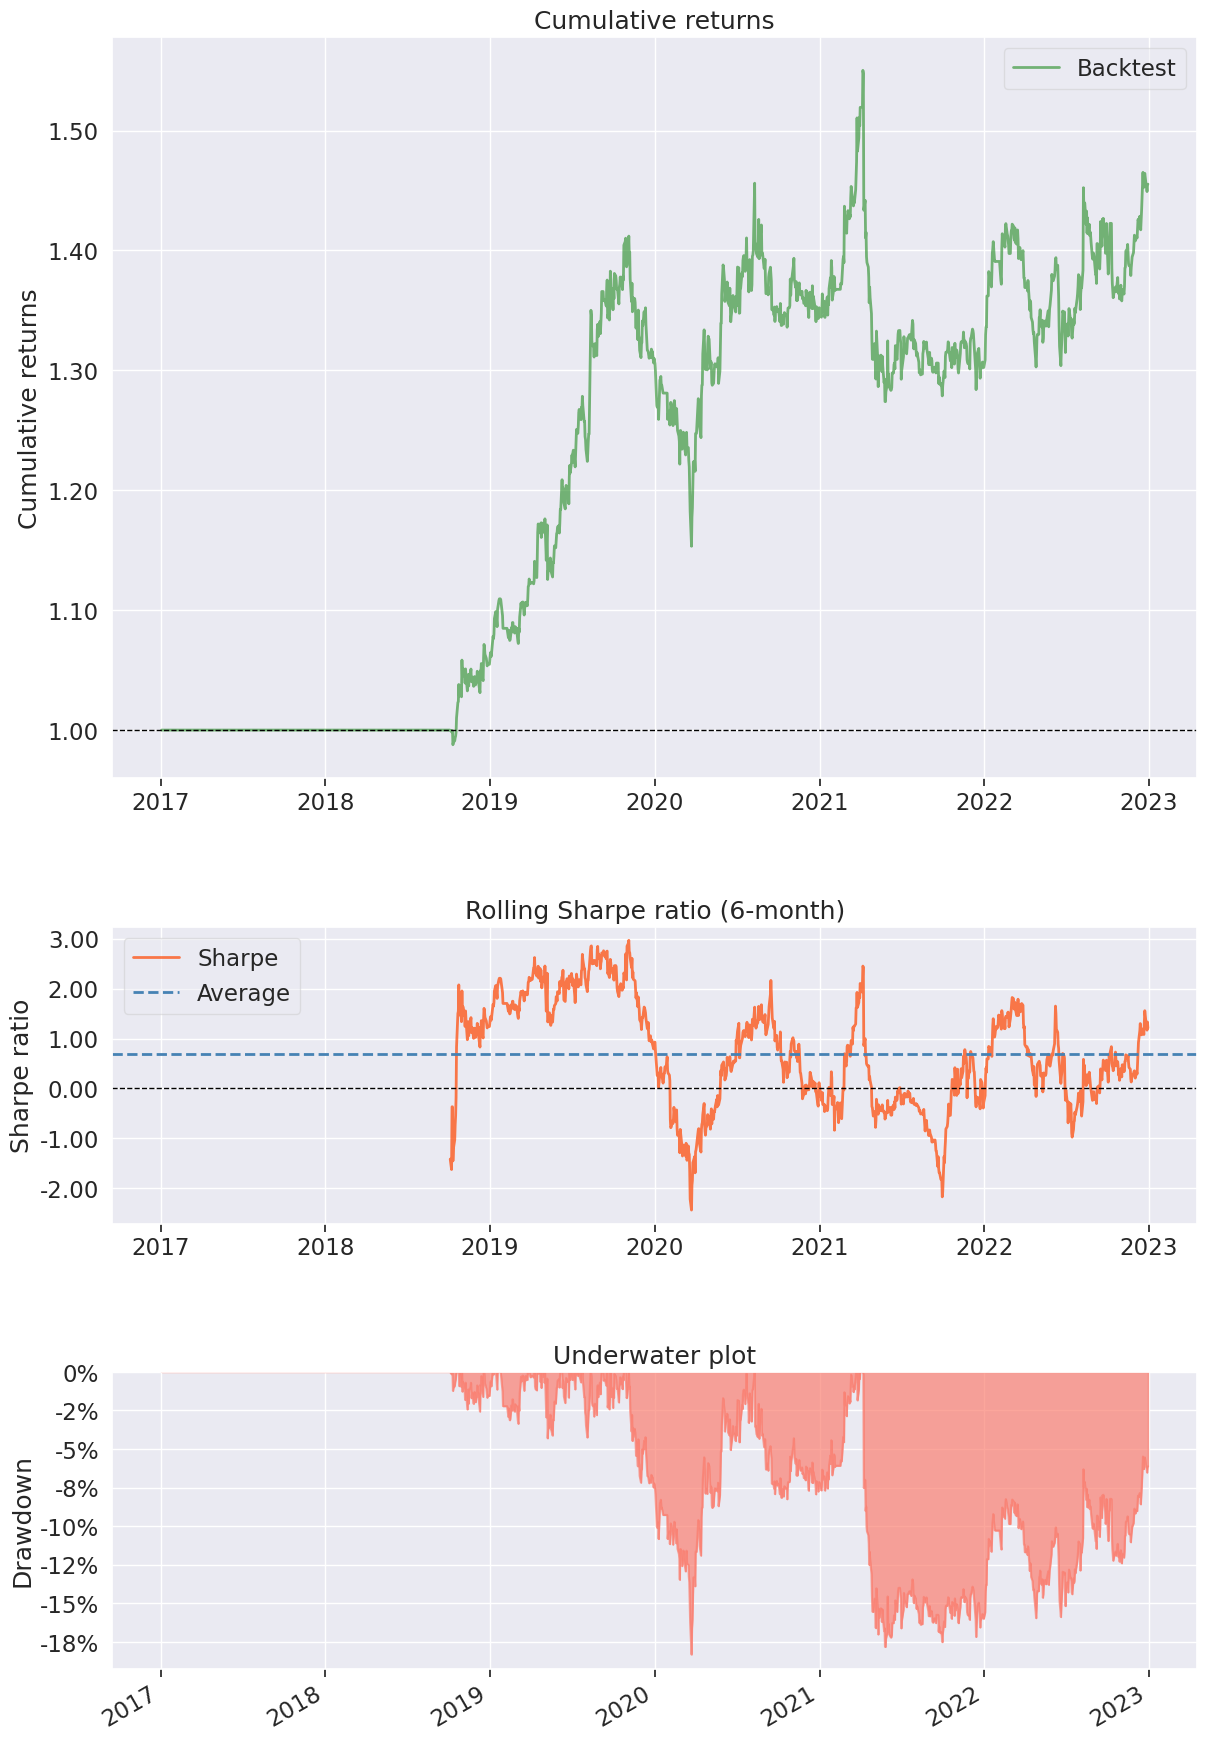

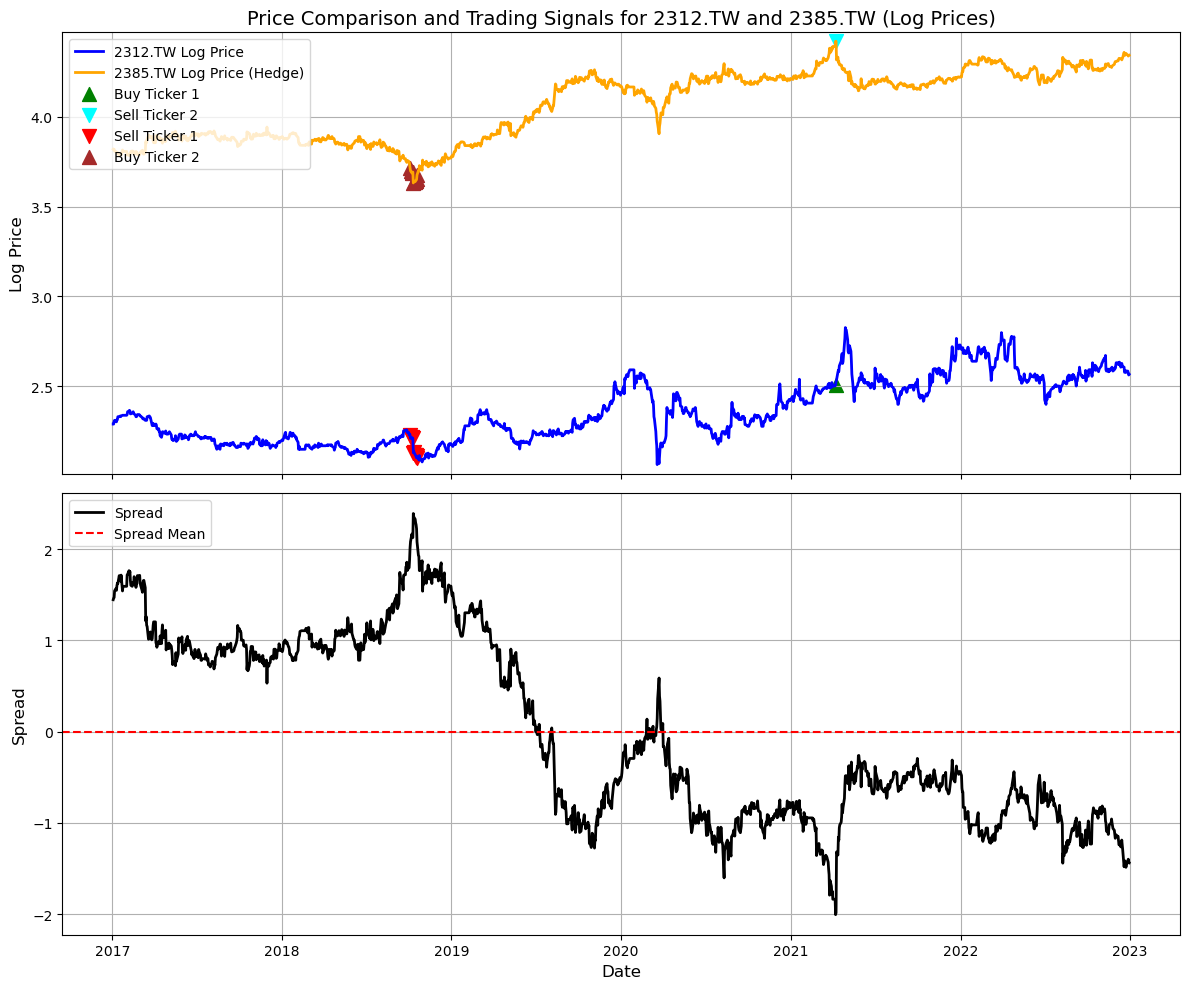

Results saved for 2312.TW and 2385.TW to 2312.TW_2385.TW_results.csv


8163.TW    Spread Signal  Volatility Mutiplier    K     2360.TW  \
Date                                                                            
2017-01-03  12.991573  2.580524   Sell                   NaN  1.2   60.787975   
2017-01-04  13.114426  2.569782   Sell                   NaN  1.2   61.107494   
2017-01-05  13.237278  2.485581   Sell                   NaN  1.0   62.305676   
2017-01-06  12.838008  2.269163   Sell                   NaN  1.0   64.302658   
2017-01-09  12.530880  2.246358   Sell                   NaN  1.0   64.063019   
...               ...       ...    ...                   ...  ...         ...   
2022-12-26  33.647587 -1.044495    NaN              6.195898  0.0  168.750458   
2022-12-27  33.471420 -1.210997    NaN              6.235767  0.0  173.964661   
2022-12-28  33.163136 -1.113115    NaN              7.049006  0.0  170.172501   
2022-12-29  33.207172 -1.210672    NaN              8.011468  0.0  173.490631   
2022-12-30  33.295254 -1.149235    NaN              9.231492  0.0  171.594559   

            8163.TW's trade  2360.TW's trade  8163.TW's position  \
Date                                                               
2017-01-03          -8132.0           8132.0             -8132.0   
2017-01-04          -6970.0           6970.0            -15102.0   
2017-01-05          -4920.0           4920.0            -20022.0   
2017-01-06          -4251.0           4251.0            -24273.0   
2017-01-09          -3761.0           3761.0            -28034.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0            -53314.0   
2022-12-27              0.0              0.0            -53314.0   
2022-12-28              0.0              0.0            -53314.0   
2022-12-29              0.0              0.0            -53314.0   
2022-12-30              0.0              0.0            -53314.0   

            2360.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03              8132.0  4.611320e+06  0.115130               1.0   
2017-01-04             15102.0  4.276808e+06  0.207662               2.0   
2017-01-05             20022.0  4.035391e+06  0.272629               3.0   
2017-01-06             24273.0  3.816615e+06  0.329130               4.0   
2017-01-09             28034.0  3.622803e+06  0.372135               5.0   
...                        ...           ...       ...               ...   
2022-12-26             53314.0  2.118194e+06  5.094268              42.0   
2022-12-27             53314.0  2.118194e+06  5.221073              42.0   
2022-12-28             53314.0  2.118194e+06  5.117867              42.0   
2022-12-29             53314.0  2.118194e+06  5.202491              42.0   
2022-12-30             53314.0  2.118194e+06  5.156985              42.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       5.001599e+06  
2017-01-05  Initiated       5.017839e+06  
2017-01-06  Initiated       5.065817e+06  
2017-01-09  Initiated       5.067455e+06  
...               ...                ...  
2022-12-26  Initiated       9.321069e+06  
2022-12-27  Initiated       9.608451e+06  
2022-12-28  Initiated       9.422712e+06  
2022-12-29  Initiated       9.597267e+06  
2022-12-30  Initiated       9.491483e+06  

[1556 rows x 15 columns]

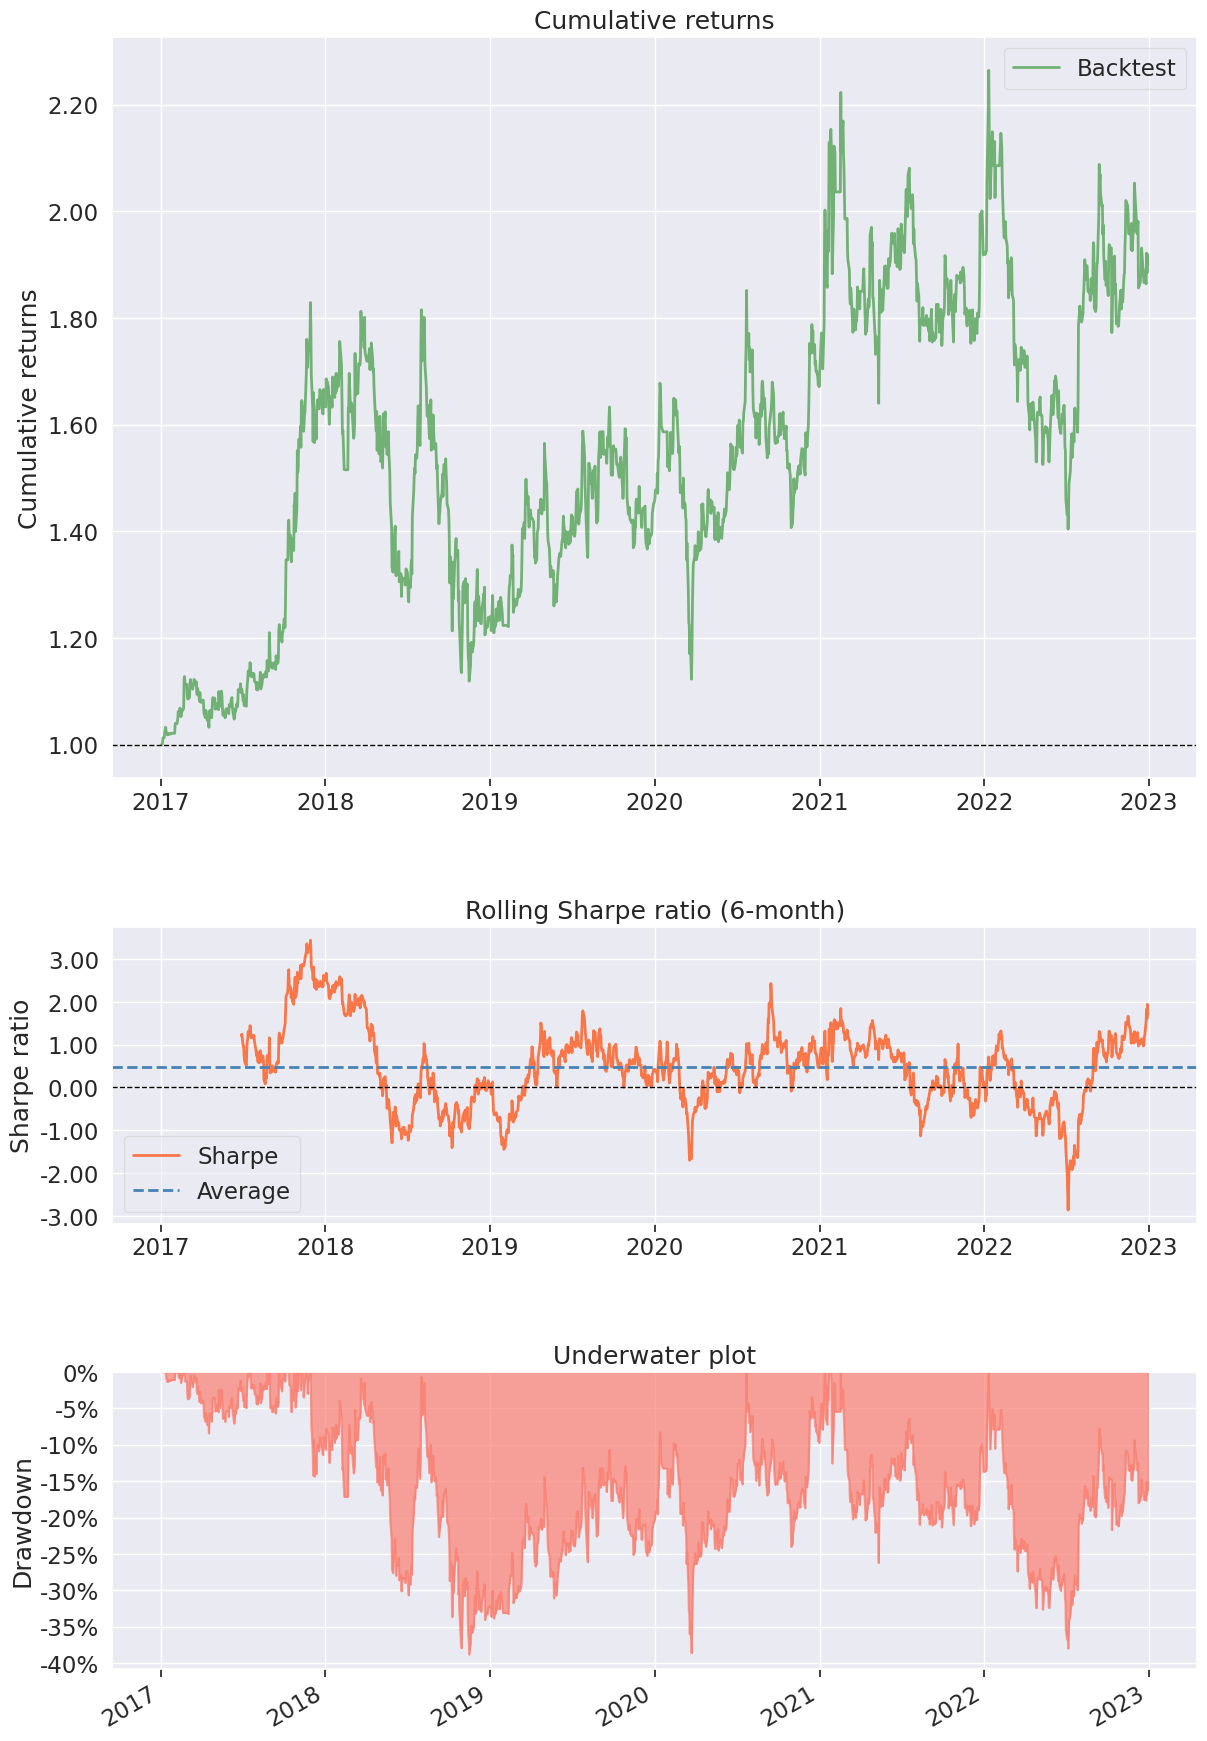

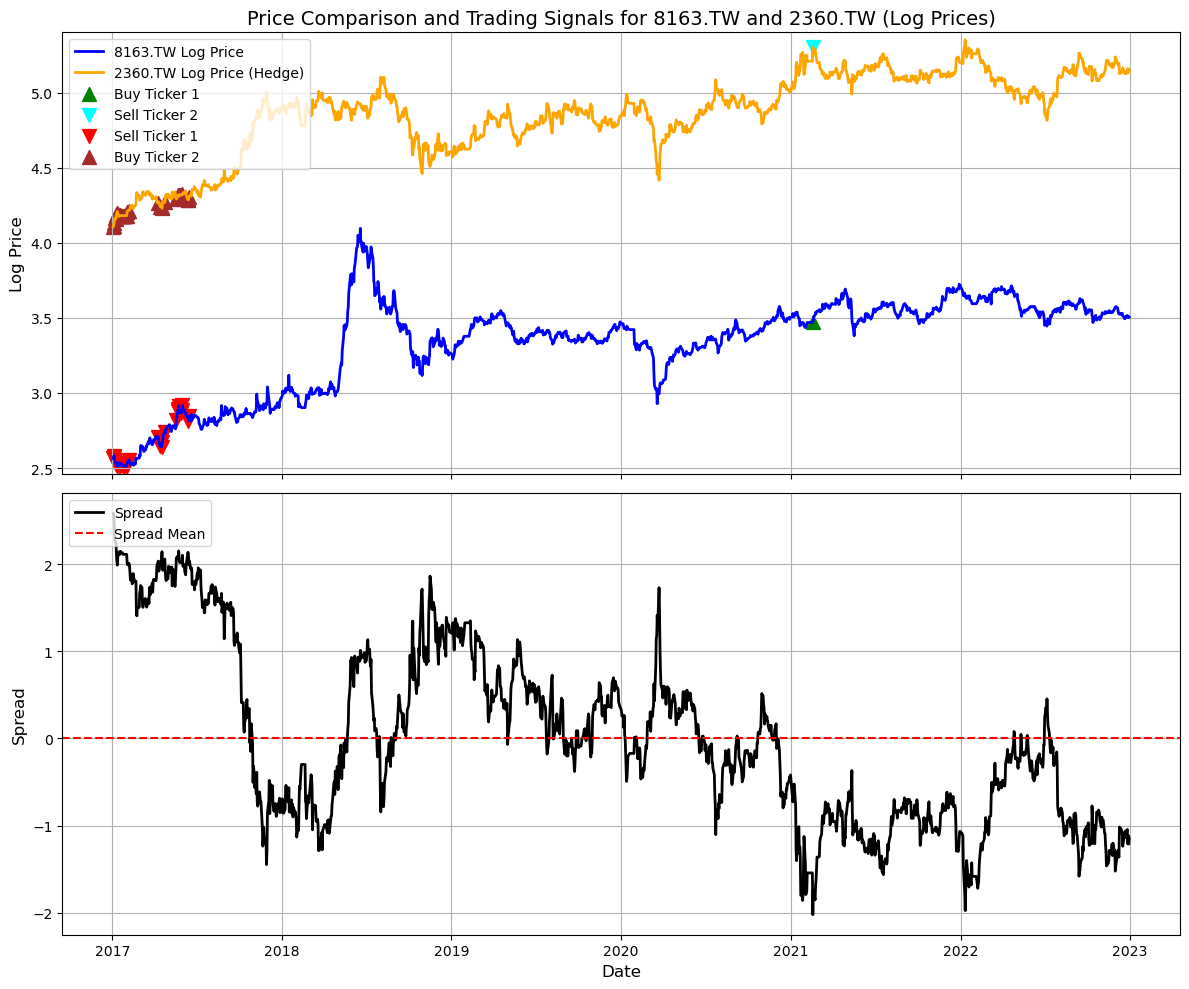

Results saved for 8163.TW and 2360.TW to 8163.TW_2360.TW_results.csv


2337.TW    Spread Signal  Volatility Mutiplier    K    2441.TW  \
Date                                                                           
2017-01-03   6.662626 -3.357521    Buy                   NaN  1.2  24.955187   
2017-01-04   6.633657 -3.349712    Buy                   NaN  1.2  24.826550   
2017-01-05   6.879885 -3.236890    Buy                   NaN  1.2  25.019508   
2017-01-06   7.299920 -2.977318    Buy                   NaN  1.2  24.955187   
2017-01-09   7.415793 -2.988807    Buy                   NaN  1.2  25.341091   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  31.845282  0.369928    NaN              9.125830  0.0  43.448242   
2022-12-27  31.938396  0.423870    NaN              9.098657  0.0  43.088047   
2022-12-28  31.286592  0.428029    NaN              9.089864  0.0  42.322643   
2022-12-29  31.426264  0.388164    NaN              9.312456  0.0  42.817905   
2022-12-30  31.426264  0.340878    NaN             10.103425  0.0  43.223122   

            2337.TW's trade  2441.TW's trade  2337.TW's position  \
Date                                                               
2017-01-03          18977.0         -18977.0             18977.0   
2017-01-04          19251.0         -19251.0             38228.0   
2017-01-05          19170.0         -19170.0             57398.0   
2017-01-06          19084.0         -19084.0             76482.0   
2017-01-09          18861.0         -18861.0             95343.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0            -60314.0   
2022-12-27              0.0              0.0            -60314.0   
2022-12-28              0.0              0.0            -60314.0   
2022-12-29              0.0              0.0            -60314.0   
2022-12-30              0.0              0.0            -60314.0   

            2441.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03            -18977.0  5.347138e+06  0.100891               1.0   
2017-01-04            -38228.0  5.697369e+06  0.174298               2.0   
2017-01-05            -57398.0  6.045106e+06  0.232472               3.0   
2017-01-06            -76482.0  6.382039e+06  0.278782               4.0   
2017-01-09            -95343.0  6.720128e+06  0.317287               5.0   
...                        ...           ...       ...               ...   
2022-12-26             60314.0  8.533191e+06  1.000000              57.0   
2022-12-27             60314.0  8.533191e+06  1.000000              57.0   
2022-12-28             60314.0  8.533191e+06  1.000000              57.0   
2022-12-29             60314.0  8.533191e+06  1.000000              57.0   
2022-12-30             60314.0  8.533191e+06  1.000000              57.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       5.001891e+06  
2017-01-05  Initiated       5.003928e+06  
2017-01-06  Initiated       5.031729e+06  
2017-01-09  Initiated       5.011076e+06  
...               ...                ...  
2022-12-26  Initiated       9.233011e+06  
2022-12-27  Initiated       9.205671e+06  
2022-12-28  Initiated       9.198819e+06  
2022-12-29  Initiated       9.220266e+06  
2022-12-30  Initiated       9.244706e+06  

[1556 rows x 15 columns]

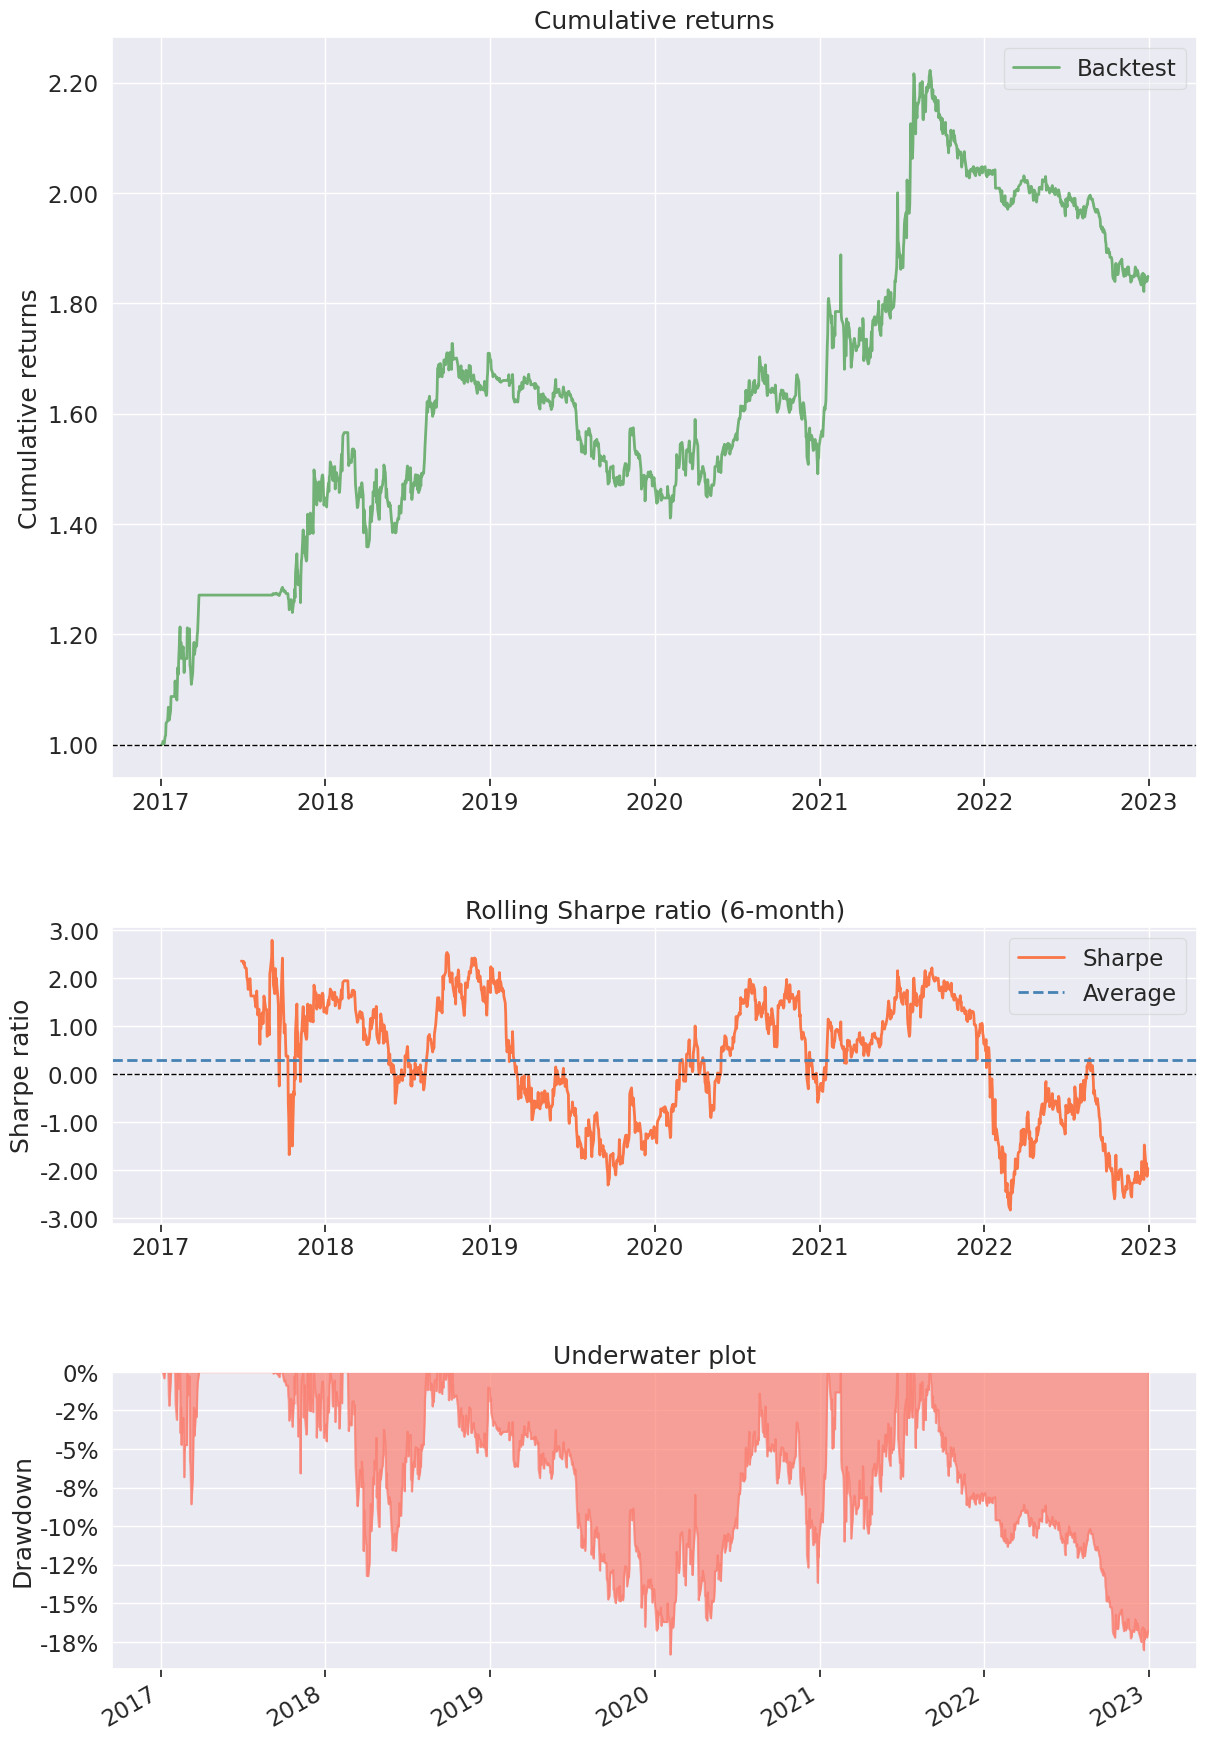

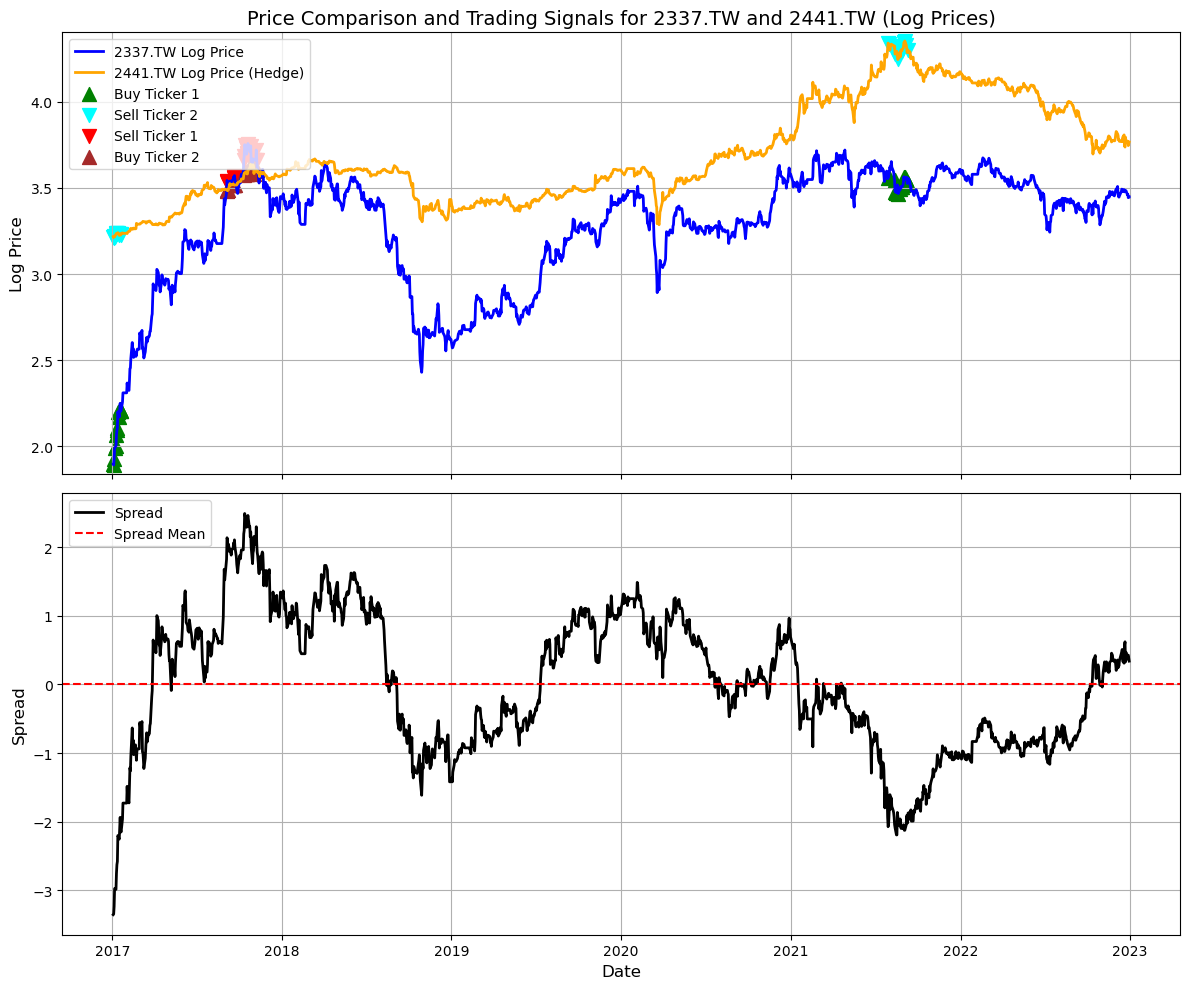

Results saved for 2337.TW and 2441.TW to 2337.TW_2441.TW_results.csv


2337.TW    Spread Signal  Volatility Mutiplier    K    2313.TW  \
Date                                                                           
2017-01-03   6.662626 -2.868044    Buy                   NaN  1.2  11.872495   
2017-01-04   6.633657 -2.904693    Buy                   NaN  1.2  11.910548   
2017-01-05   6.879885 -2.749168    Buy                   NaN  1.2  11.986654   
2017-01-06   7.299920 -2.520851    Buy                   NaN  1.2  12.176917   
2017-01-09   7.415793 -2.455323    Buy                   NaN  1.0  12.214970   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  31.845282 -0.761049    NaN              6.039623  0.0  42.524921   
2022-12-27  31.938396 -0.775826    NaN              5.980609  0.0  42.801655   
2022-12-28  31.286592 -0.720310    NaN              5.909460  0.0  41.325733   
2022-12-29  31.426264 -0.718055    NaN              5.852476  0.0  41.510227   
2022-12-30  31.426264 -0.667133    NaN              5.936983  0.0  41.049000   

            2337.TW's trade  2313.TW's trade  2337.TW's position  \
Date                                                               
2017-01-03          32371.0         -32371.0             32371.0   
2017-01-04          31505.0         -31505.0             63876.0   
2017-01-05          30165.0         -30165.0             94041.0   
2017-01-06          28353.0         -28353.0            122394.0   
2017-01-09          22594.0         -22594.0            144988.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0           -179737.0   
2022-12-27              0.0              0.0           -179737.0   
2022-12-28              0.0              0.0           -179737.0   
2022-12-29              0.0              0.0           -179737.0   
2022-12-30              0.0              0.0           -179737.0   

            2313.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03            -32371.0  5.168649e+06  0.104011               1.0   
2017-01-04            -63876.0  5.334897e+06  0.181692               2.0   
2017-01-05            -94041.0  5.488943e+06  0.244277               3.0   
2017-01-06           -122394.0  5.627220e+06  0.297569               4.0   
2017-01-09           -144988.0  5.735653e+06  0.331655               5.0   
...                        ...           ...       ...               ...   
2022-12-26            179737.0  8.751728e+06  1.527364              57.0   
2022-12-27            179737.0  8.751728e+06  1.534960              57.0   
2022-12-28            179737.0  8.751728e+06  1.491262              57.0   
2022-12-29            179737.0  8.751728e+06  1.497920              57.0   
2022-12-30            179737.0  8.751728e+06  1.488447              57.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       4.997830e+06  
2017-01-05  Initiated       5.008697e+06  
2017-01-06  Initiated       5.030305e+06  
2017-01-09  Initiated       5.039830e+06  
...               ...                ...  
2022-12-26  Initiated       1.067125e+07  
2022-12-27  Initiated       1.070426e+07  
2022-12-28  Initiated       1.055613e+07  
2022-12-29  Initiated       1.056419e+07  
2022-12-30  Initiated       1.048129e+07  

[1556 rows x 15 columns]

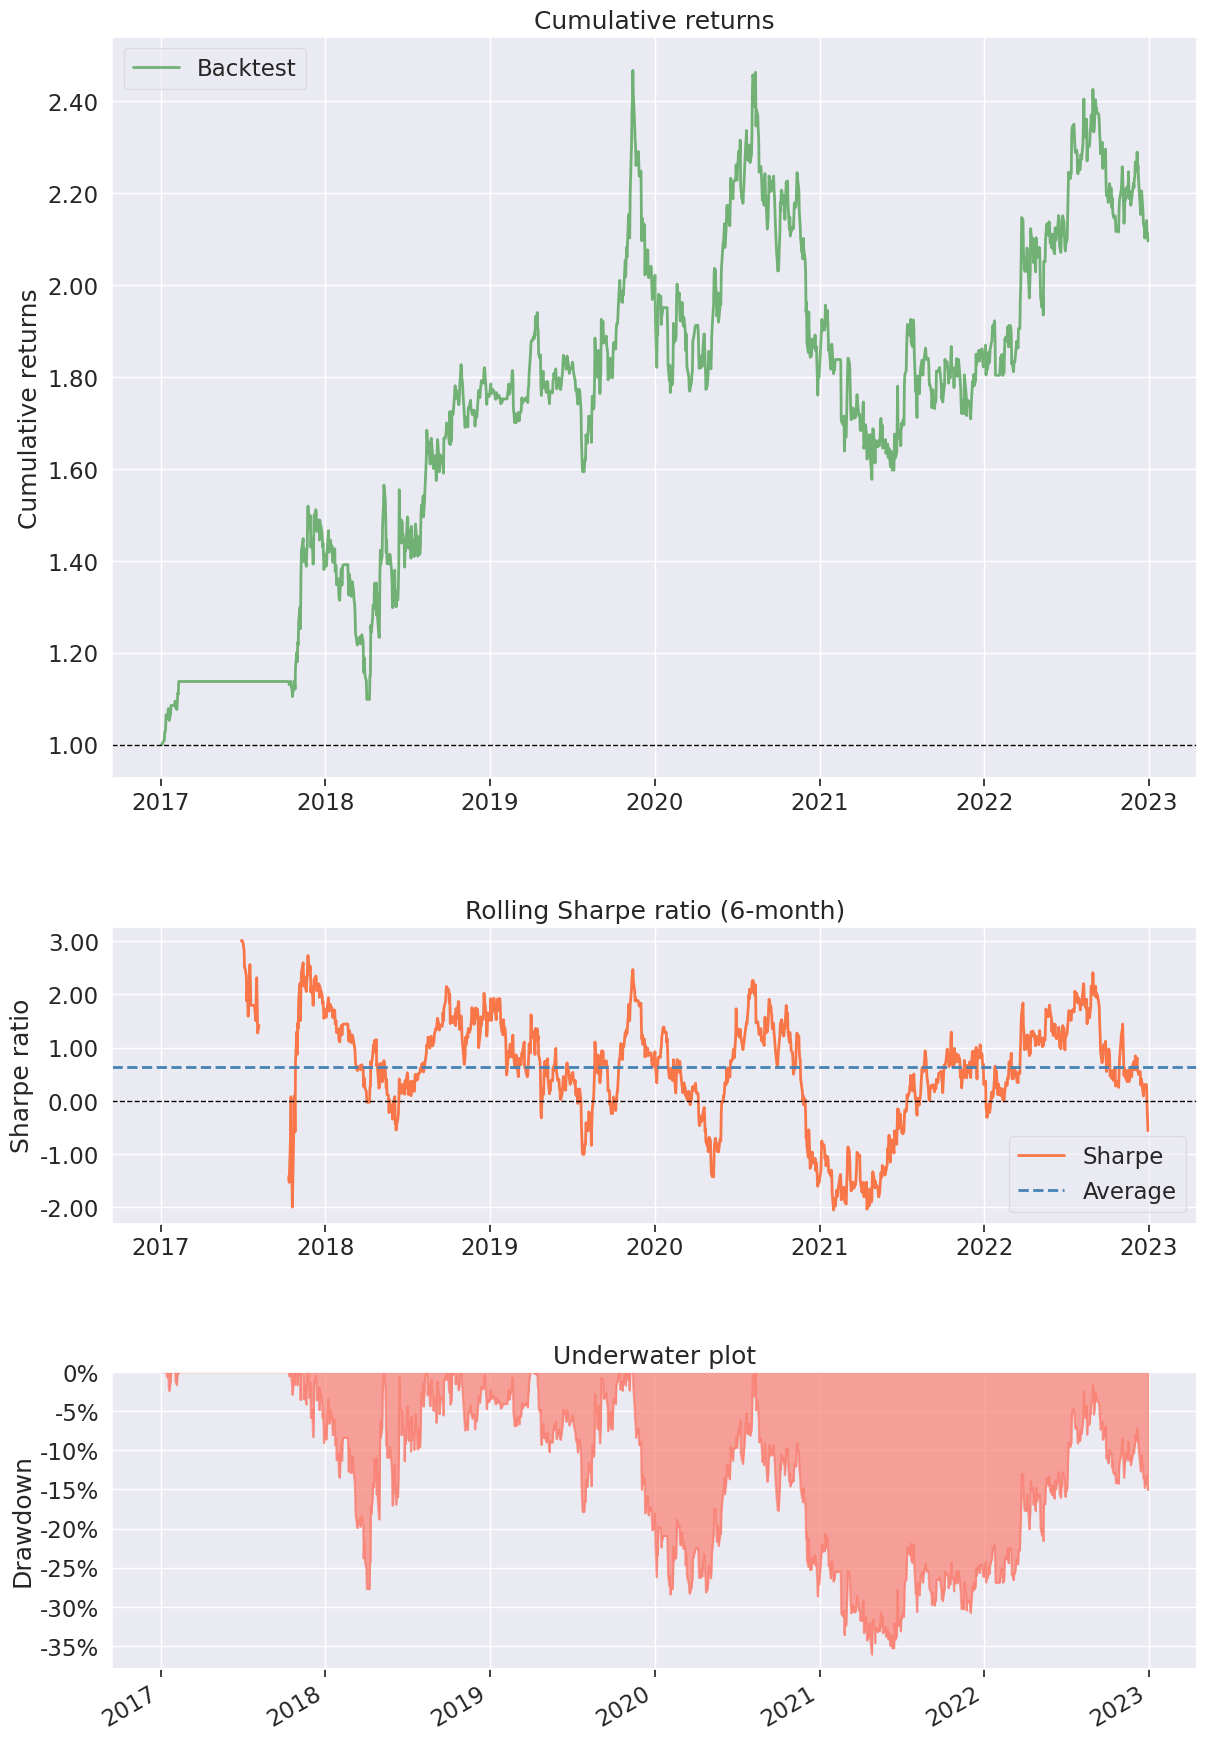

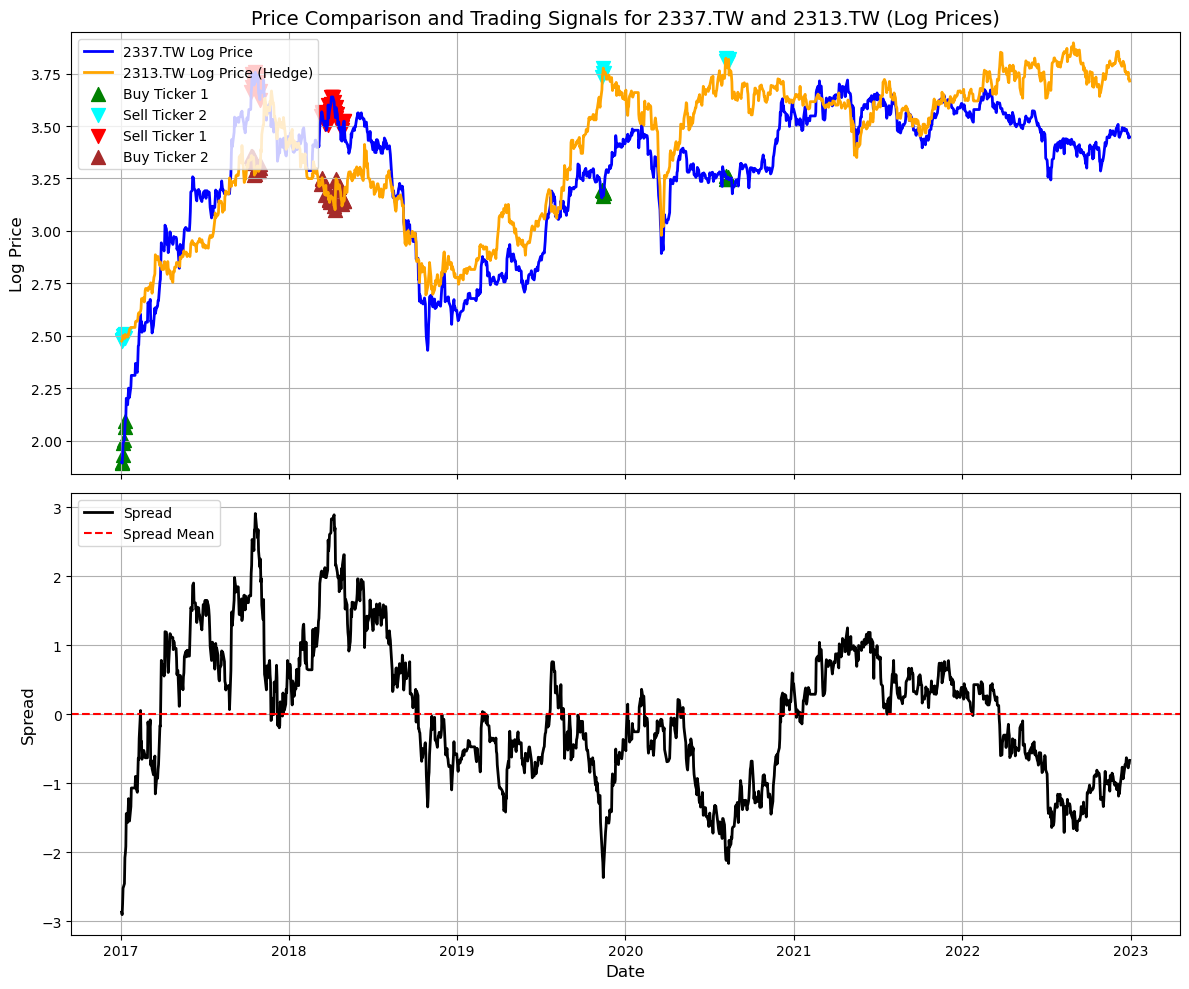

Results saved for 2337.TW and 2313.TW to 2337.TW_2313.TW_results.csv


2337.TW    Spread Signal  Volatility Mutiplier    K    2392.TW  \
Date                                                                           
2017-01-03   6.662626 -4.843165    Buy                   NaN  1.2  25.158493   
2017-01-04   6.633657 -4.864764    Buy                   NaN  1.2  25.226767   
2017-01-05   6.879885 -4.736170    Buy                   NaN  1.2  25.329176   
2017-01-06   7.299920 -4.503704    Buy                   NaN  1.2  25.192629   
2017-01-09   7.415793 -4.442084    Buy                   NaN  1.2  25.158493   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  31.845282  0.407293    NaN             13.027757  0.0  34.372543   
2022-12-27  31.938396  0.407750    NaN             13.463688  0.0  34.557842   
2022-12-28  31.286592  0.364788    NaN             13.650805  0.0  33.955631   
2022-12-29  31.426264  0.365584    NaN             13.538341  0.0  34.233574   
2022-12-30  31.426264  0.368222    NaN             13.538854  0.0  34.187252   

            2337.TW's trade  2392.TW's trade  2337.TW's position  \
Date                                                               
2017-01-03          18855.0         -18855.0             18855.0   
2017-01-04          19016.0         -19016.0             37871.0   
2017-01-05          18997.0         -18997.0             56868.0   
2017-01-06          18972.0         -18972.0             75840.0   
2017-01-09          19009.0         -19009.0             94849.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0                 0.0   
2022-12-27              0.0              0.0                 0.0   
2022-12-28              0.0              0.0                 0.0   
2022-12-29              0.0              0.0                 0.0   
2022-12-30              0.0              0.0                 0.0   

            2392.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03            -18855.0  5.348740e+06  0.100860               1.0   
2017-01-04            -37871.0  5.702306e+06  0.174642               2.0   
2017-01-05            -56868.0  6.052787e+06  0.232314               3.0   
2017-01-06            -75840.0  6.392248e+06  0.278241               4.0   
2017-01-09            -94849.0  6.729519e+06  0.314654               5.0   
...                        ...           ...       ...               ...   
2022-12-26                 0.0  1.338337e+07  1.000000              67.0   
2022-12-27                 0.0  1.338337e+07  1.000000              67.0   
2022-12-28                 0.0  1.338337e+07  1.000000              67.0   
2022-12-29                 0.0  1.338337e+07  1.000000              67.0   
2022-12-30                 0.0  1.338337e+07  1.000000              67.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       4.998167e+06  
2017-01-05  Initiated       5.003613e+06  
2017-01-06  Initiated       5.035265e+06  
2017-01-09  Initiated       5.046641e+06  
...               ...                ...  
2022-12-26     Closed       1.338337e+07  
2022-12-27     Closed       1.338337e+07  
2022-12-28     Closed       1.338337e+07  
2022-12-29     Closed       1.338337e+07  
2022-12-30     Closed       1.338337e+07  

[1556 rows x 15 columns]

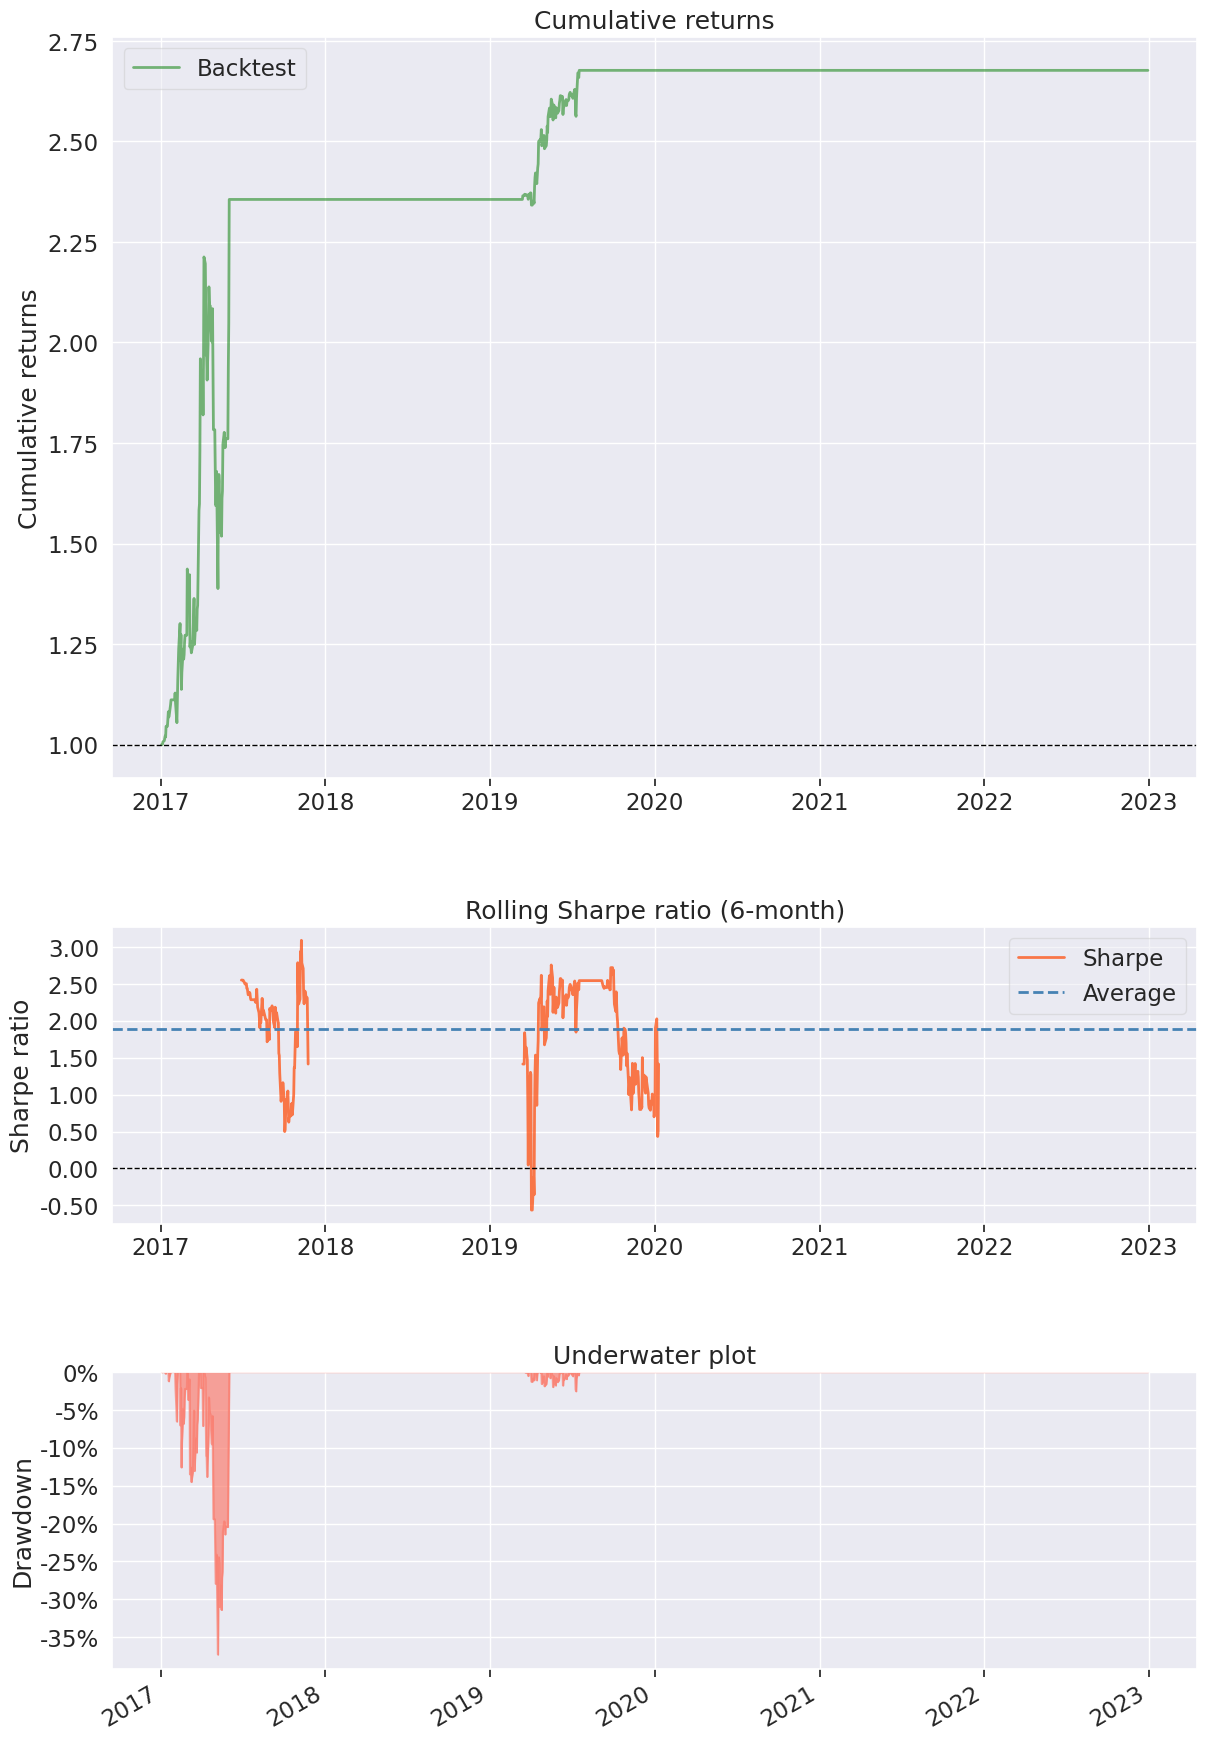

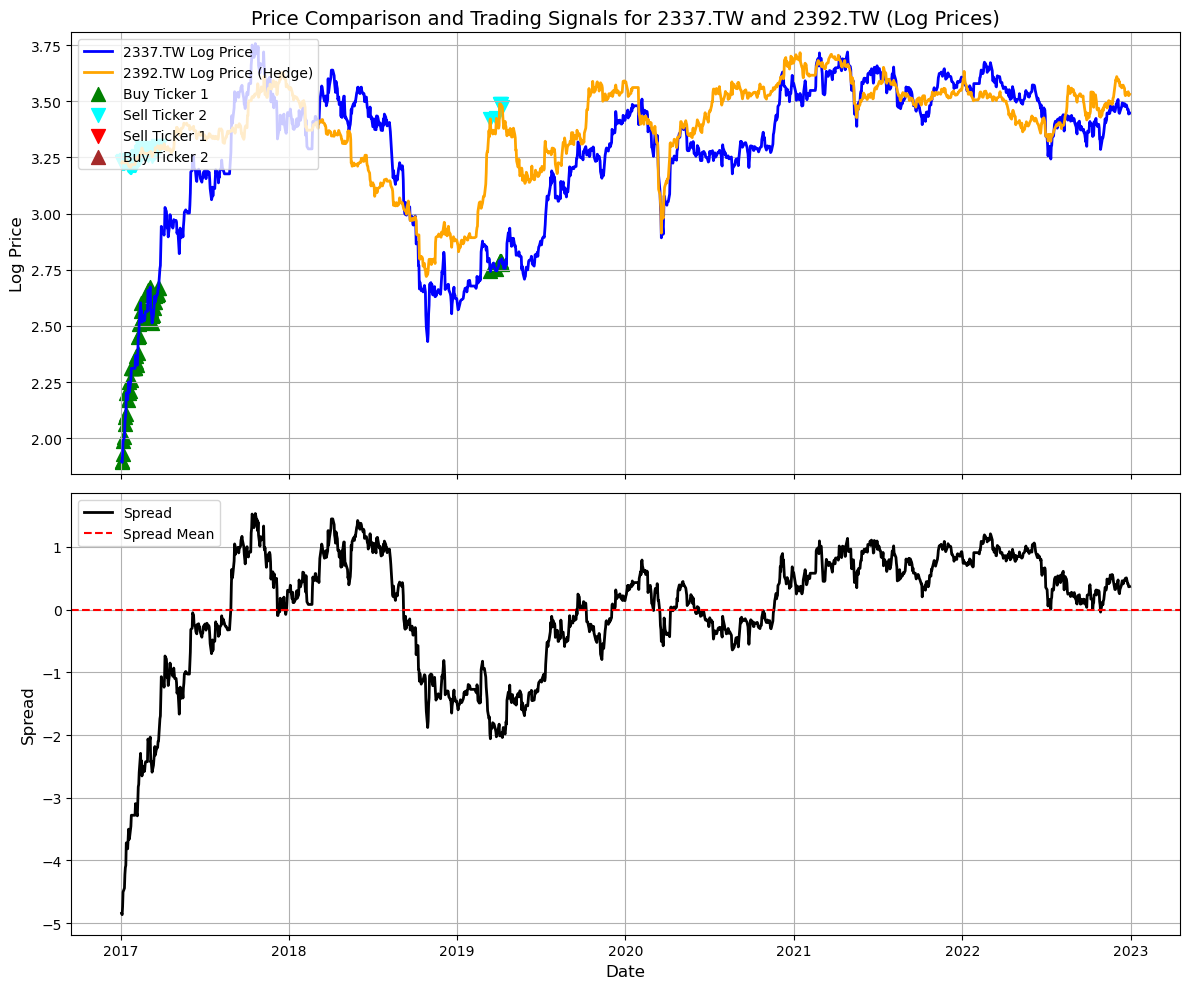

Results saved for 2337.TW and 2392.TW to 2337.TW_2392.TW_results.csv


2337.TW    Spread Signal  Volatility Mutiplier    K    3711.TW  \
Date                                                                           
2017-01-03   6.662626 -3.565197    Buy                   NaN  1.2  45.965416   
2017-01-04   6.633657 -3.581734    Buy                   NaN  1.2  45.965416   
2017-01-05   6.879885 -3.518848    Buy                   NaN  1.2  46.596039   
2017-01-06   7.299920 -3.433678    Buy                   NaN  1.2  47.787220   
2017-01-09   7.415793 -3.390119    Buy                   NaN  1.2  47.927361   
...               ...       ...    ...                   ...  ...        ...   
2022-12-26  31.845282 -1.002474    NaN              7.273072  0.0  84.558746   
2022-12-27  31.938396 -1.020761    NaN              7.165547  0.0  85.008522   
2022-12-28  31.286592 -1.040123    NaN              7.081935  0.0  84.108963   
2022-12-29  31.426264 -1.040952    NaN              7.407649  0.0  84.378838   
2022-12-30  31.426264 -1.046850    NaN              7.751420  0.0  84.468788   

            2337.TW's trade  3711.TW's trade  2337.TW's position  \
Date                                                               
2017-01-03          11401.0         -11401.0             11401.0   
2017-01-04          11745.0         -11745.0             23146.0   
2017-01-05          11896.0         -11896.0             35042.0   
2017-01-06          11862.0         -11862.0             46904.0   
2017-01-09          12079.0         -12079.0             58983.0   
...                     ...              ...                 ...   
2022-12-26              0.0              0.0                 0.0   
2022-12-27              0.0              0.0                 0.0   
2022-12-28              0.0              0.0                 0.0   
2022-12-29              0.0              0.0                 0.0   
2022-12-30              0.0              0.0                 0.0   

            3711.TW's position          Cash  Leverage  Number of trades  \
Date                                                                       
2017-01-03            -11401.0  5.448091e+06  0.099207               1.0   
2017-01-04            -23146.0  5.910043e+06  0.170811               2.0   
2017-01-05            -35042.0  6.382506e+06  0.226963               3.0   
2017-01-06            -46904.0  6.862766e+06  0.273518               4.0   
2017-01-09            -58983.0  7.352106e+06  0.307477               5.0   
...                        ...           ...       ...               ...   
2022-12-26                 0.0  7.722221e+06  1.000000              37.0   
2022-12-27                 0.0  7.722221e+06  1.000000              37.0   
2022-12-28                 0.0  7.722221e+06  1.000000              37.0   
2022-12-29                 0.0  7.722221e+06  1.000000              37.0   
2022-12-30                 0.0  7.722221e+06  1.000000              37.0   

               Status  Portfolio's Value  
Date                                      
2017-01-03  Initiated       5.000000e+06  
2017-01-04  Initiated       4.999670e+06  
2017-01-05  Initiated       4.990773e+06  
2017-01-06  Initiated       4.963750e+06  
2017-01-09  Initiated       4.962612e+06  
...               ...                ...  
2022-12-26     Closed       7.722221e+06  
2022-12-27     Closed       7.722221e+06  
2022-12-28     Closed       7.722221e+06  
2022-12-29     Closed       7.722221e+06  
2022-12-30     Closed       7.722221e+06  

[1556 rows x 15 columns]

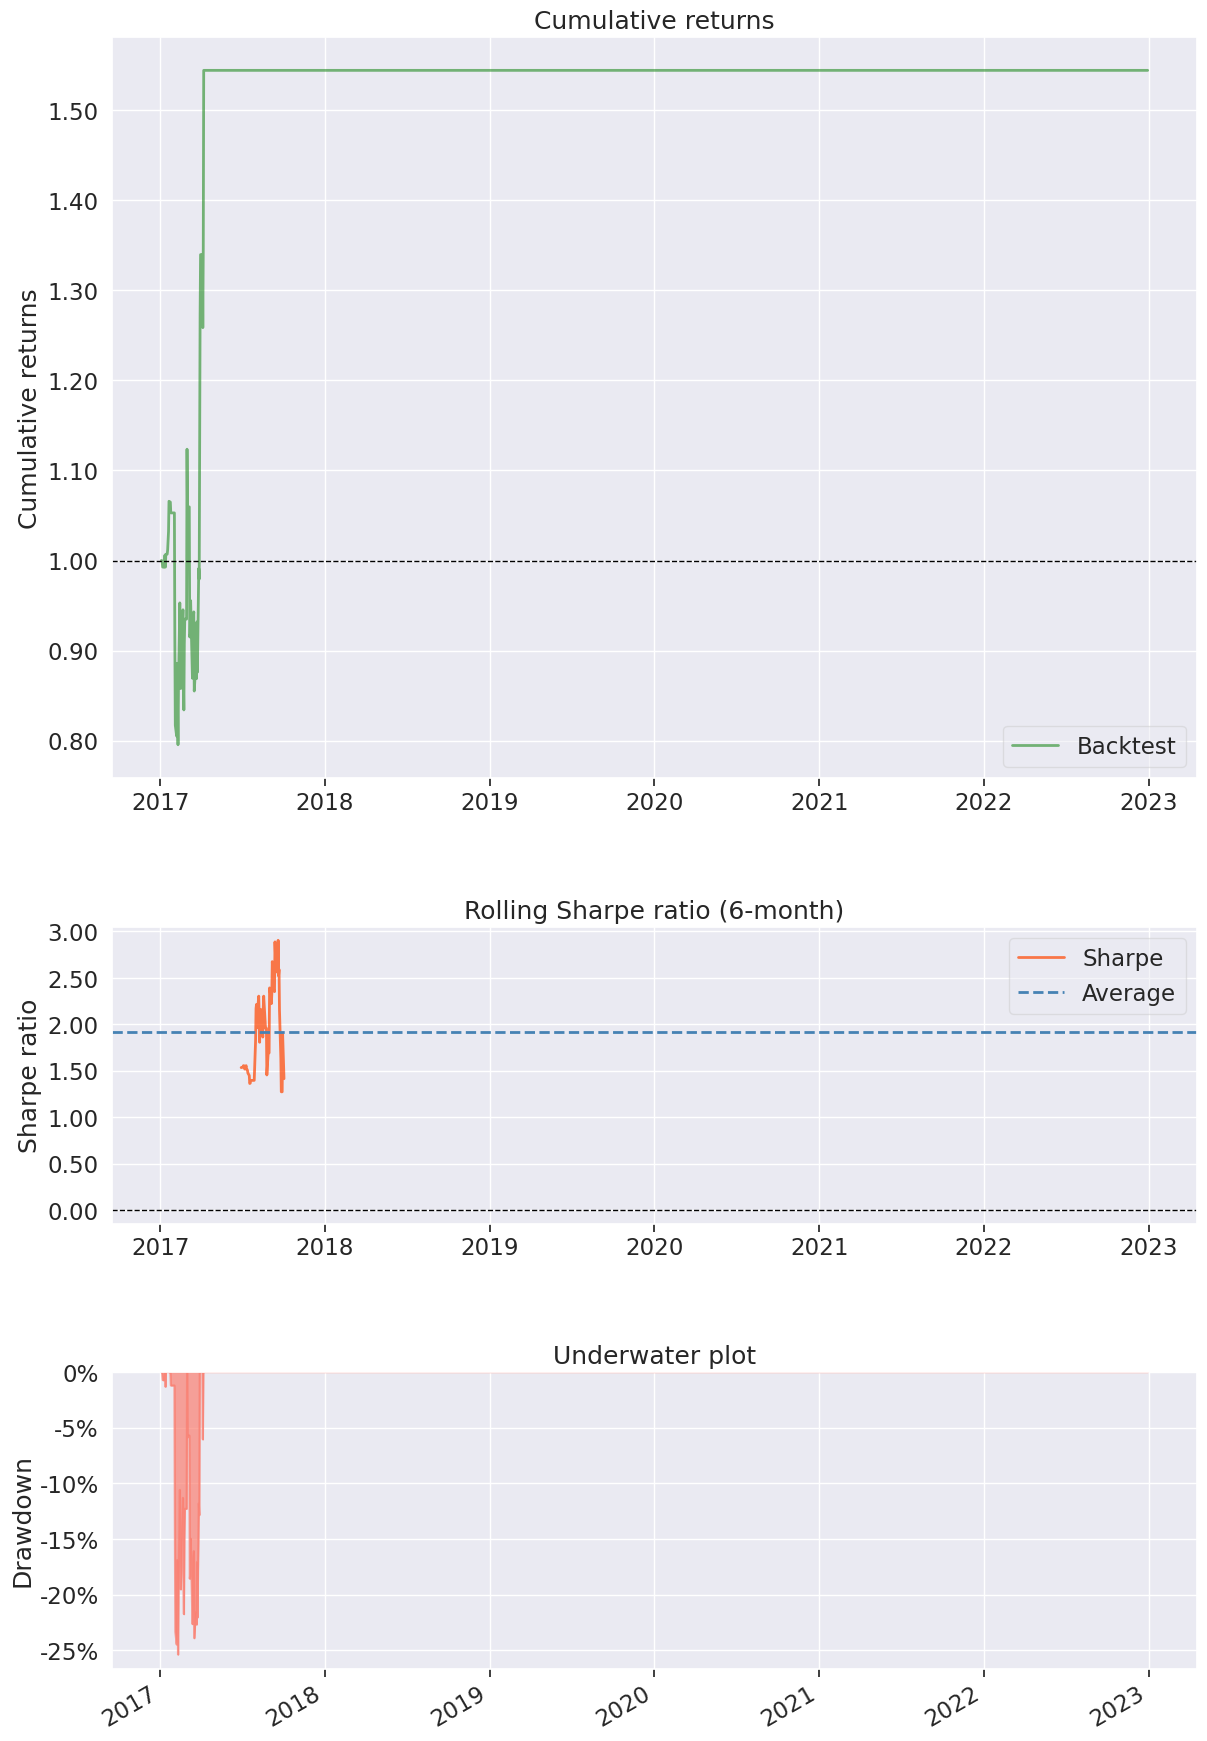

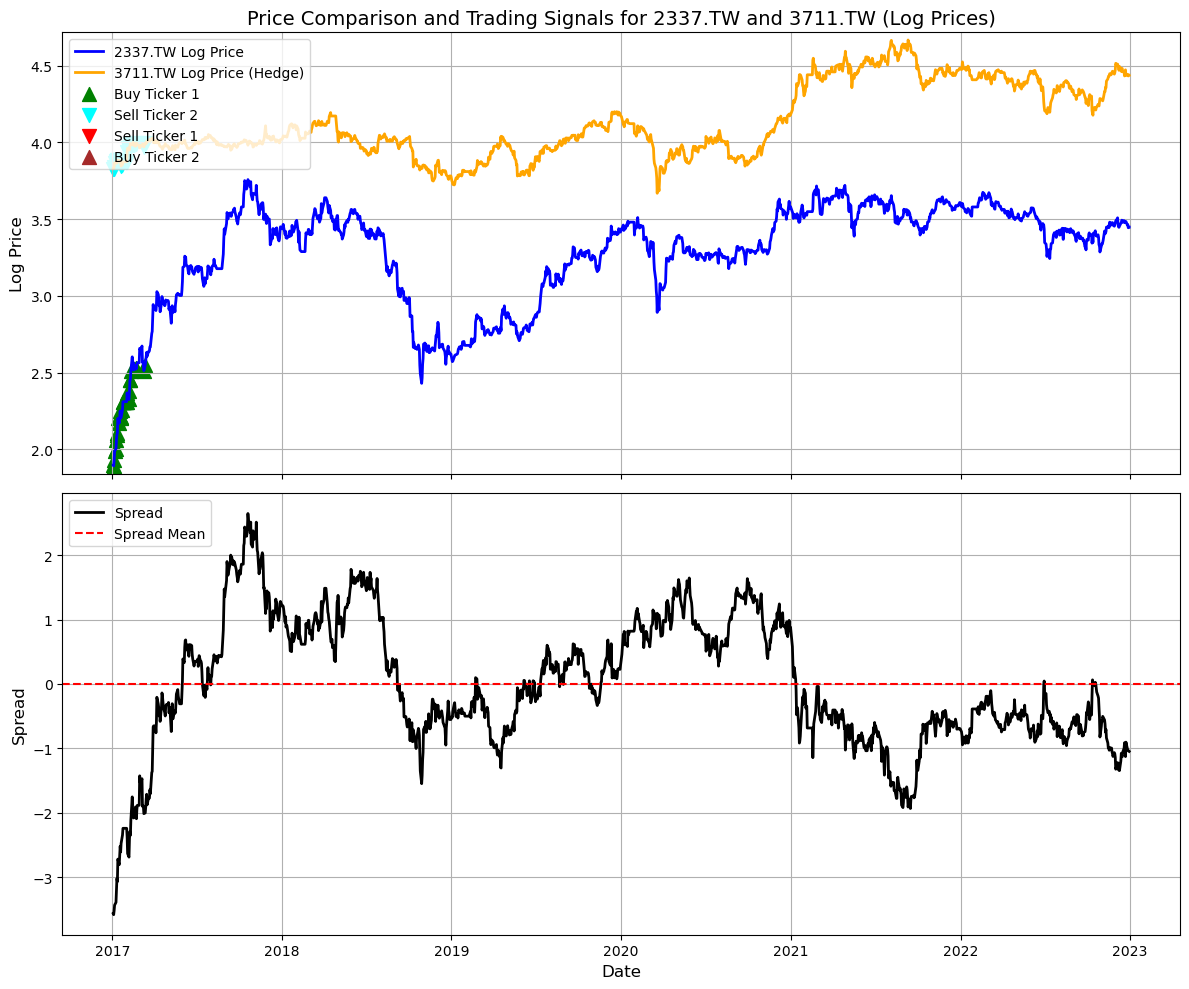

Results saved for 2337.TW and 3711.TW to 2337.TW_3711.TW_results.csv


In [ ]:
import os
for index, row in FPairs.iterrows():
    ticker1 = row[0]
    ticker2 = row[1]
    Price_df = Strategy.position(ticker1,ticker2)
    display(Price_df)
    performance = Strategy.metric(Price_df)
    Strategy.signal_plot(Price_df, HR)

    # Define the path and filename dynamically
    path = "C:\\Users\\User\\Desktop\\Analysis\\Personal Research"
    filename = f"{ticker1}_{ticker2}_results.csv"
    full_path = os.path.join(path, filename)

    # Save the portfolio DataFrame to CSV
    Price_df.to_csv(full_path, index=False)
    print(f"Results saved for {ticker1} and {ticker2} to {filename}")
